# Import Libraries & Set Up
---

In [1]:
import warnings
import logging
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import bnlearn as bn
from pgmpy.global_vars import logger
from utils import * # Helper functions

In [2]:
warnings.filterwarnings('ignore')
logger.setLevel(logging.ERROR)
logging.getLogger('seaborn').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('pandas').setLevel(logging.ERROR)

palette = ['#800080', '#8A2BE2', '#FF69B4', '#DA70D6', '#9370DB', '#DDA0DD', '#BA55D3']
gradient_palette = sns.light_palette('#620080', as_cmap=True)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
sns.set_theme(style="whitegrid", palette=palette)

# Dementia
---

Let's import the processed dataset.

In [3]:
dementia_df = pd.read_csv('data/dementia_data_processed.csv')

## Discretising the Data
---

To prepare the data for a discrete BN, we must first discretise the data into bins.

In [4]:
dementia_df_5bins = discretise(dementia_df.copy(), nbins=5)
dementia_df_sturges = discretise(dementia_df.copy(), method='sturges')
dementia_df_freedman_diaconis = discretise(dementia_df.copy(), method='freedman-diaconis')

Then we can plot this discretised data to see the effects.

### 5 Bin Discretisation
---

In [5]:
dementia_df_5bins.head()

Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
0      1         1    4    1     1    1     2    2     2     0    2      1
1      0         0    4    1     2    3     4    0     0     1    3      0
2      0         0    0    1     2    2     4    1     1     2    2      1
3      0         0    4    1     2    1     4    0     1     2    2      0
4      0         0    0    1     1    3     4    0     2     2    2      0

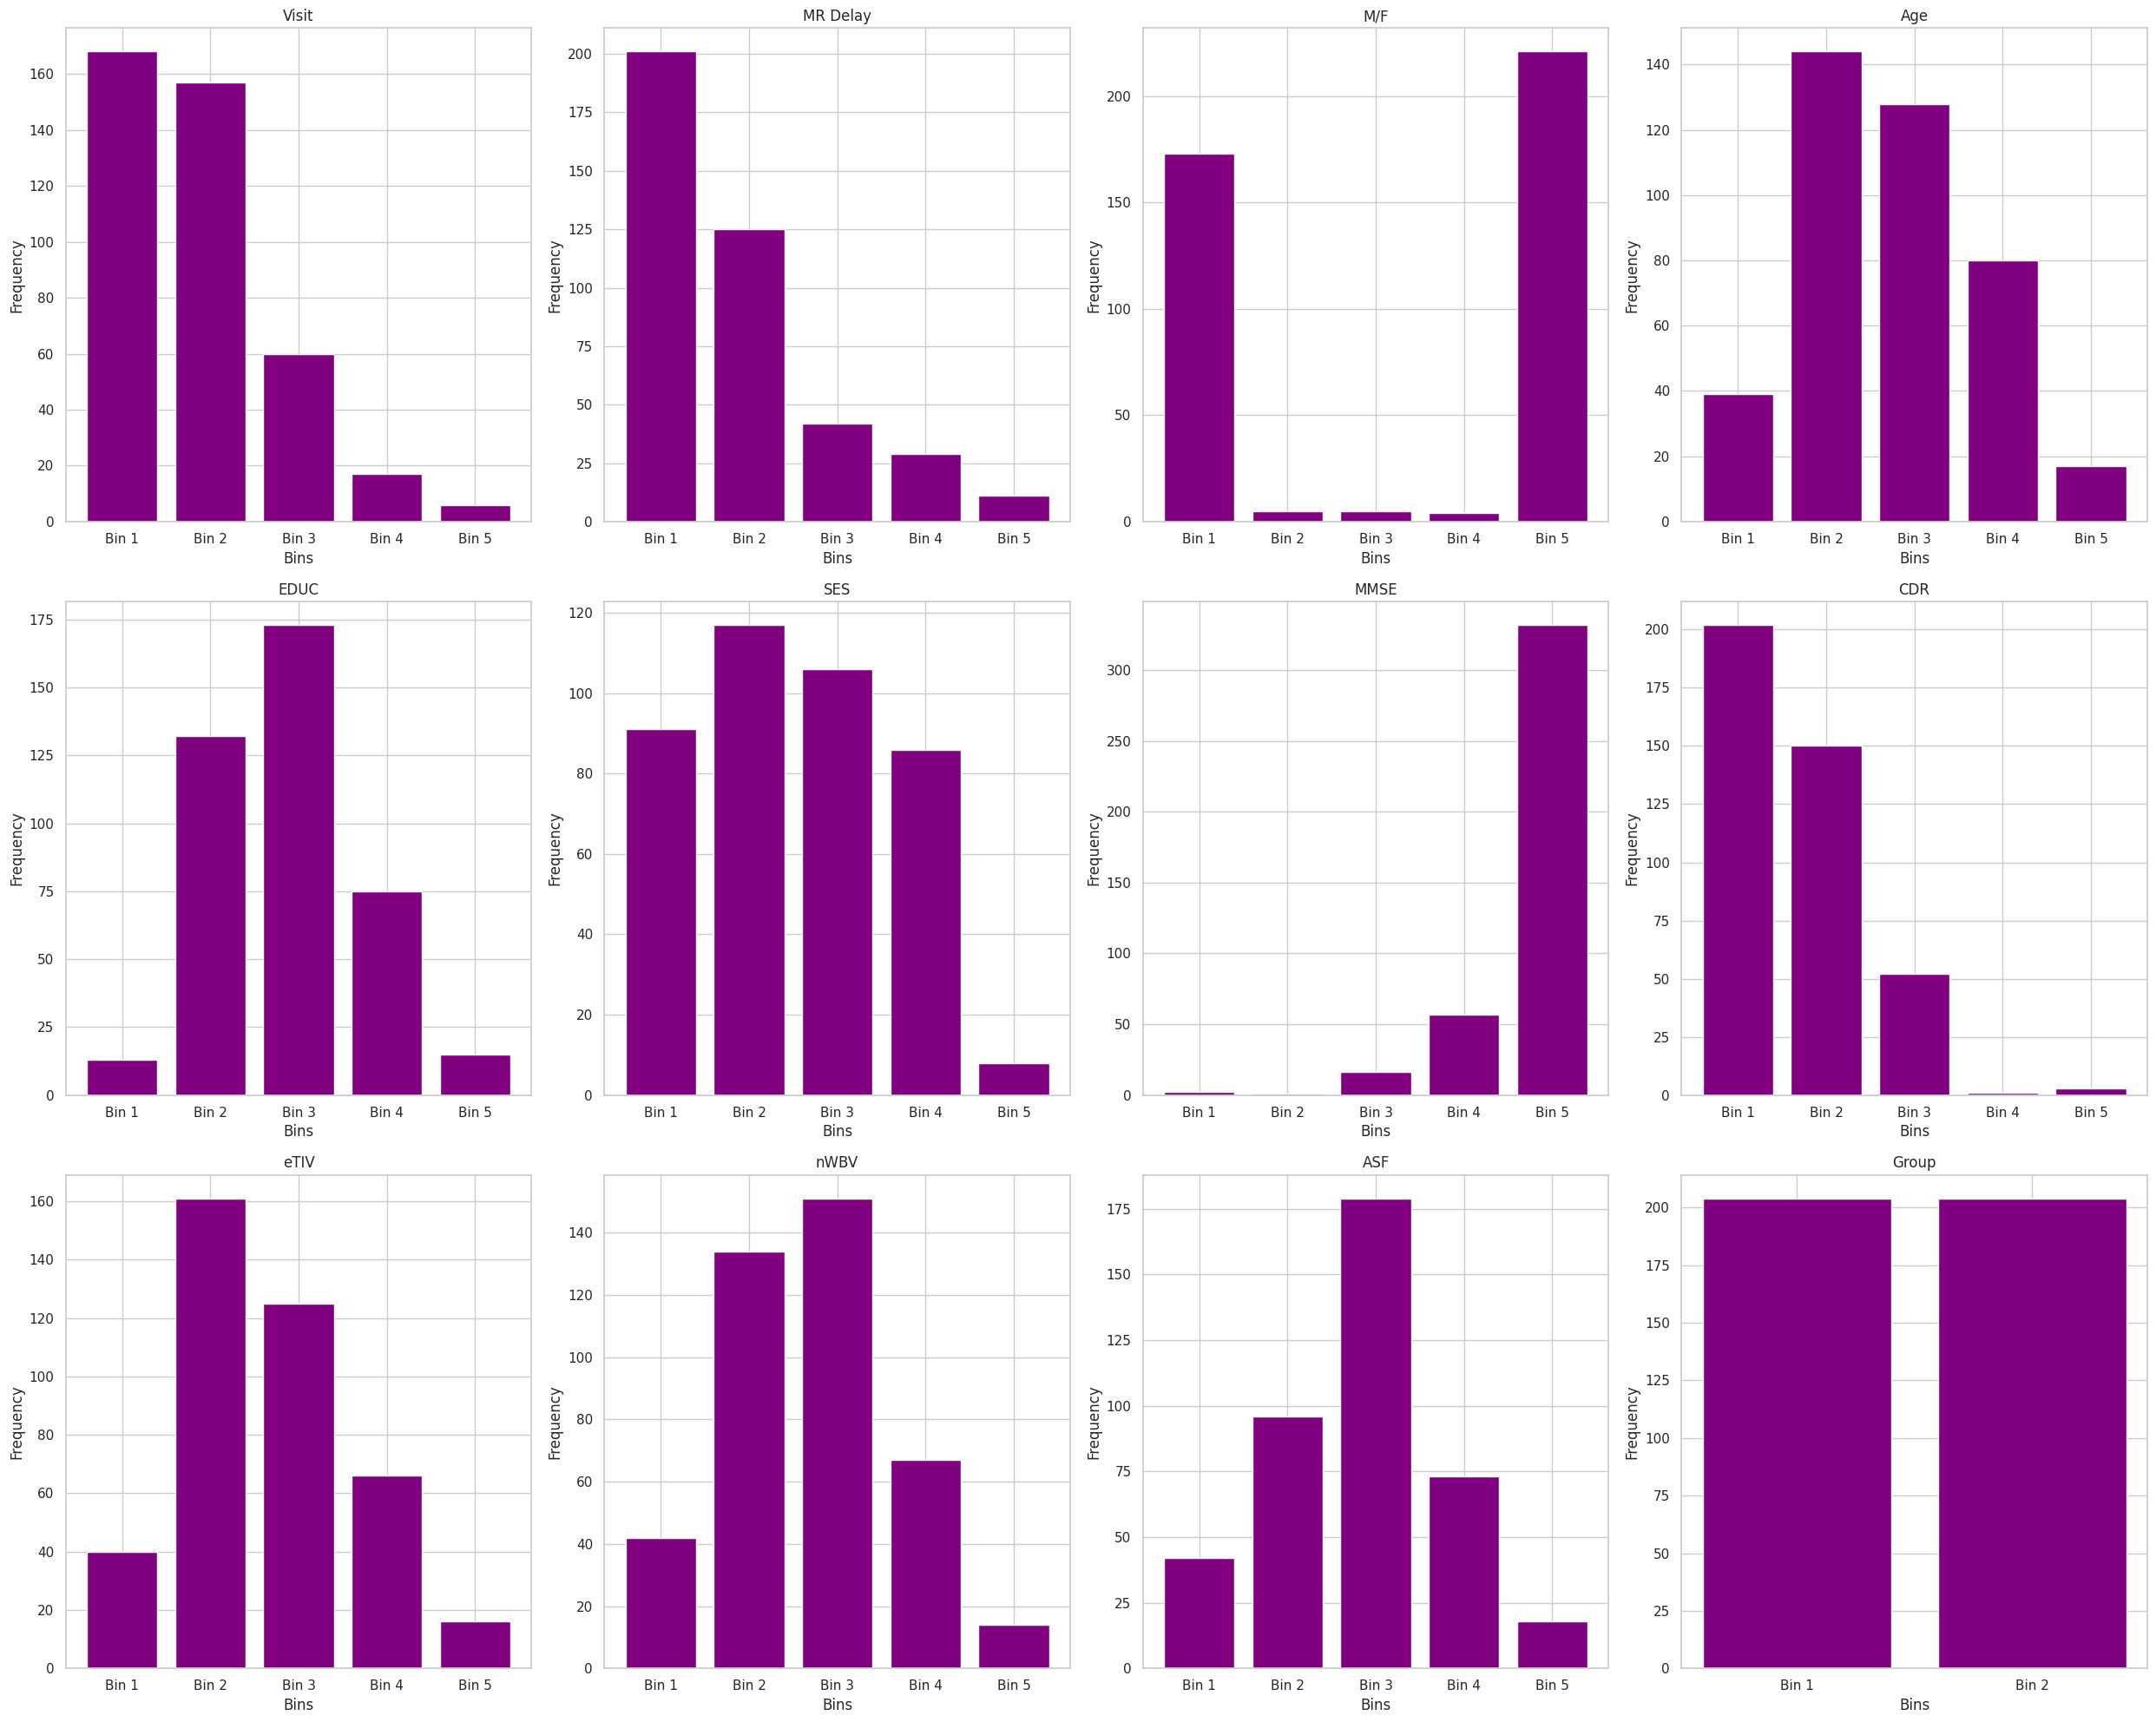

In [6]:
plot_bins_barcharts(dementia_df_5bins)

### Sturges Formula Discretisation
---

In [7]:
dementia_df_sturges.head()

Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
0      2         2    9    3     3    2     5    4     4     0    4      1
1      0         0    9    3     5    7     9    0     1     2    7      0
2      0         0    0    2     5    4     9    2     2     5    5      1
3      0         0    9    2     4    2     9    0     3     5    4      0
4      0         0    0    3     3    7     9    0     4     4    4      0

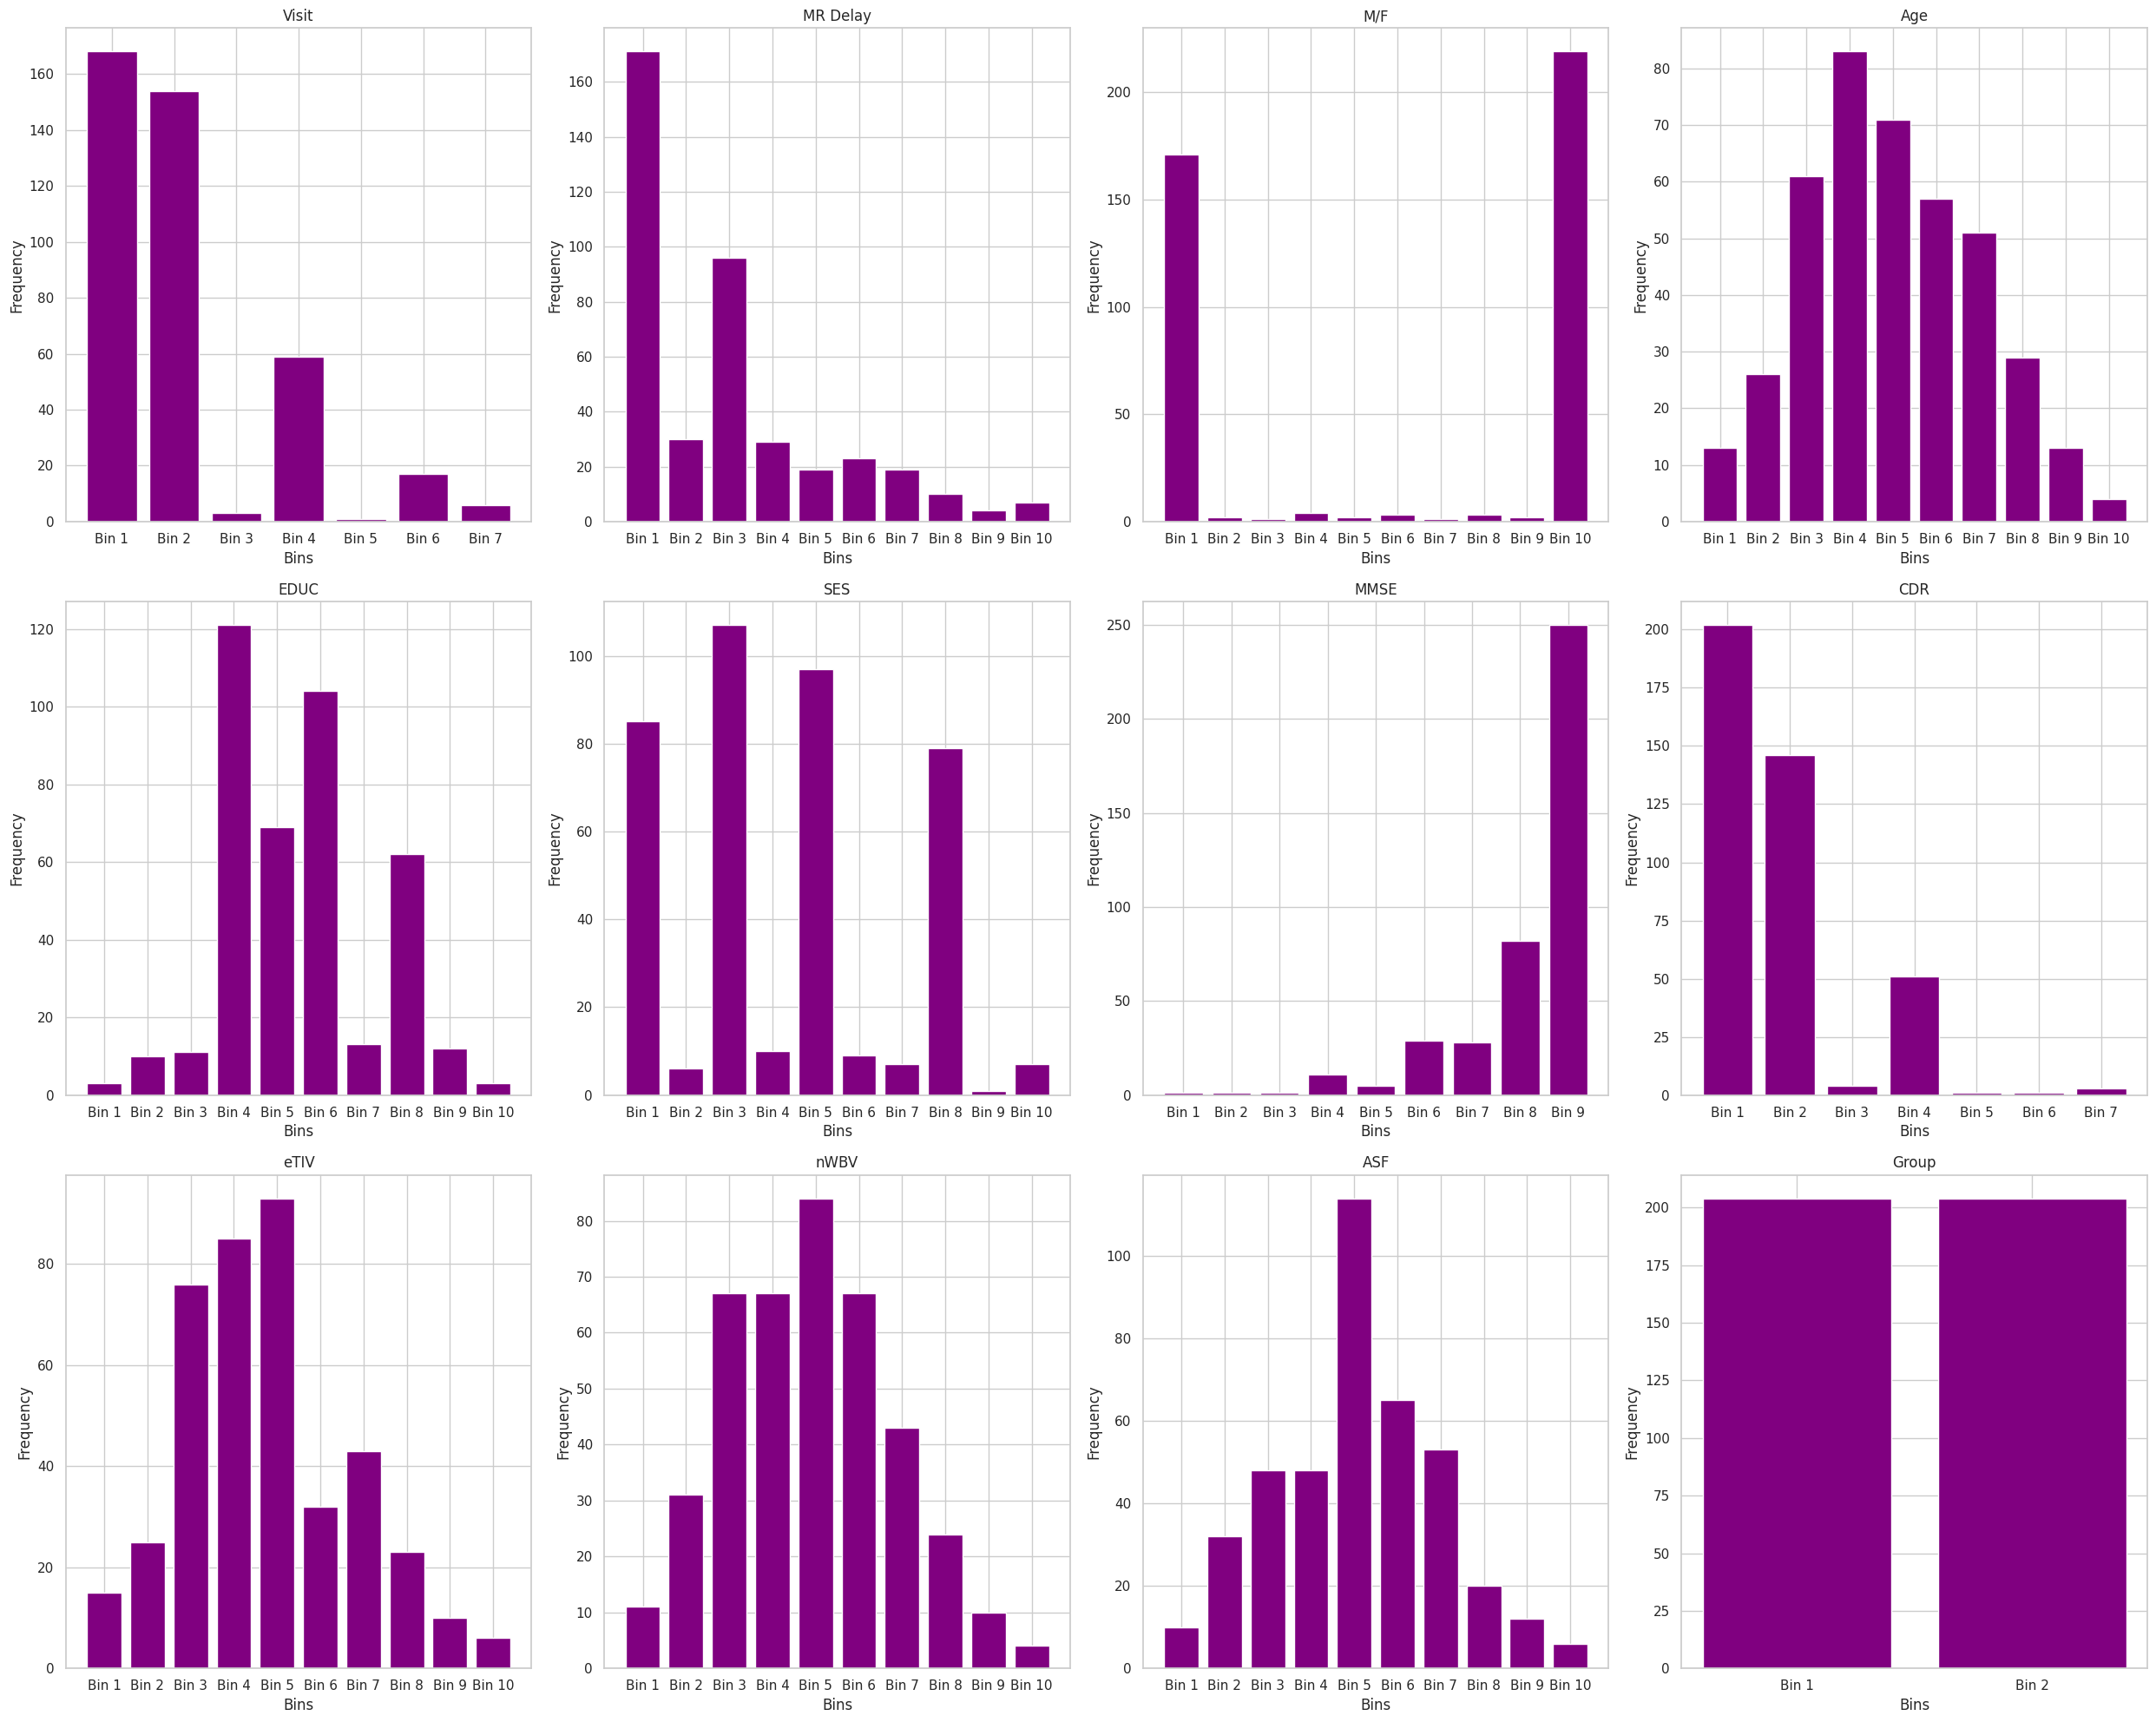

In [8]:
plot_bins_barcharts(dementia_df_sturges)

### Freedman Diaconis Rule Discretisation
---

In [9]:
dementia_df_freedman_diaconis.head()

Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
0      3         3    3    5     5    3    13    7     6     0    6      1
1      0         0    3    5     8   11    24    0     2     3   10      0
2      0         0    0    4     9    7    23    3     4     7    8      1
3      0         0    3    4     7    3    23    0     6     8    6      0
4      0         0    0    5     5   11    23    0     7     6    6      0

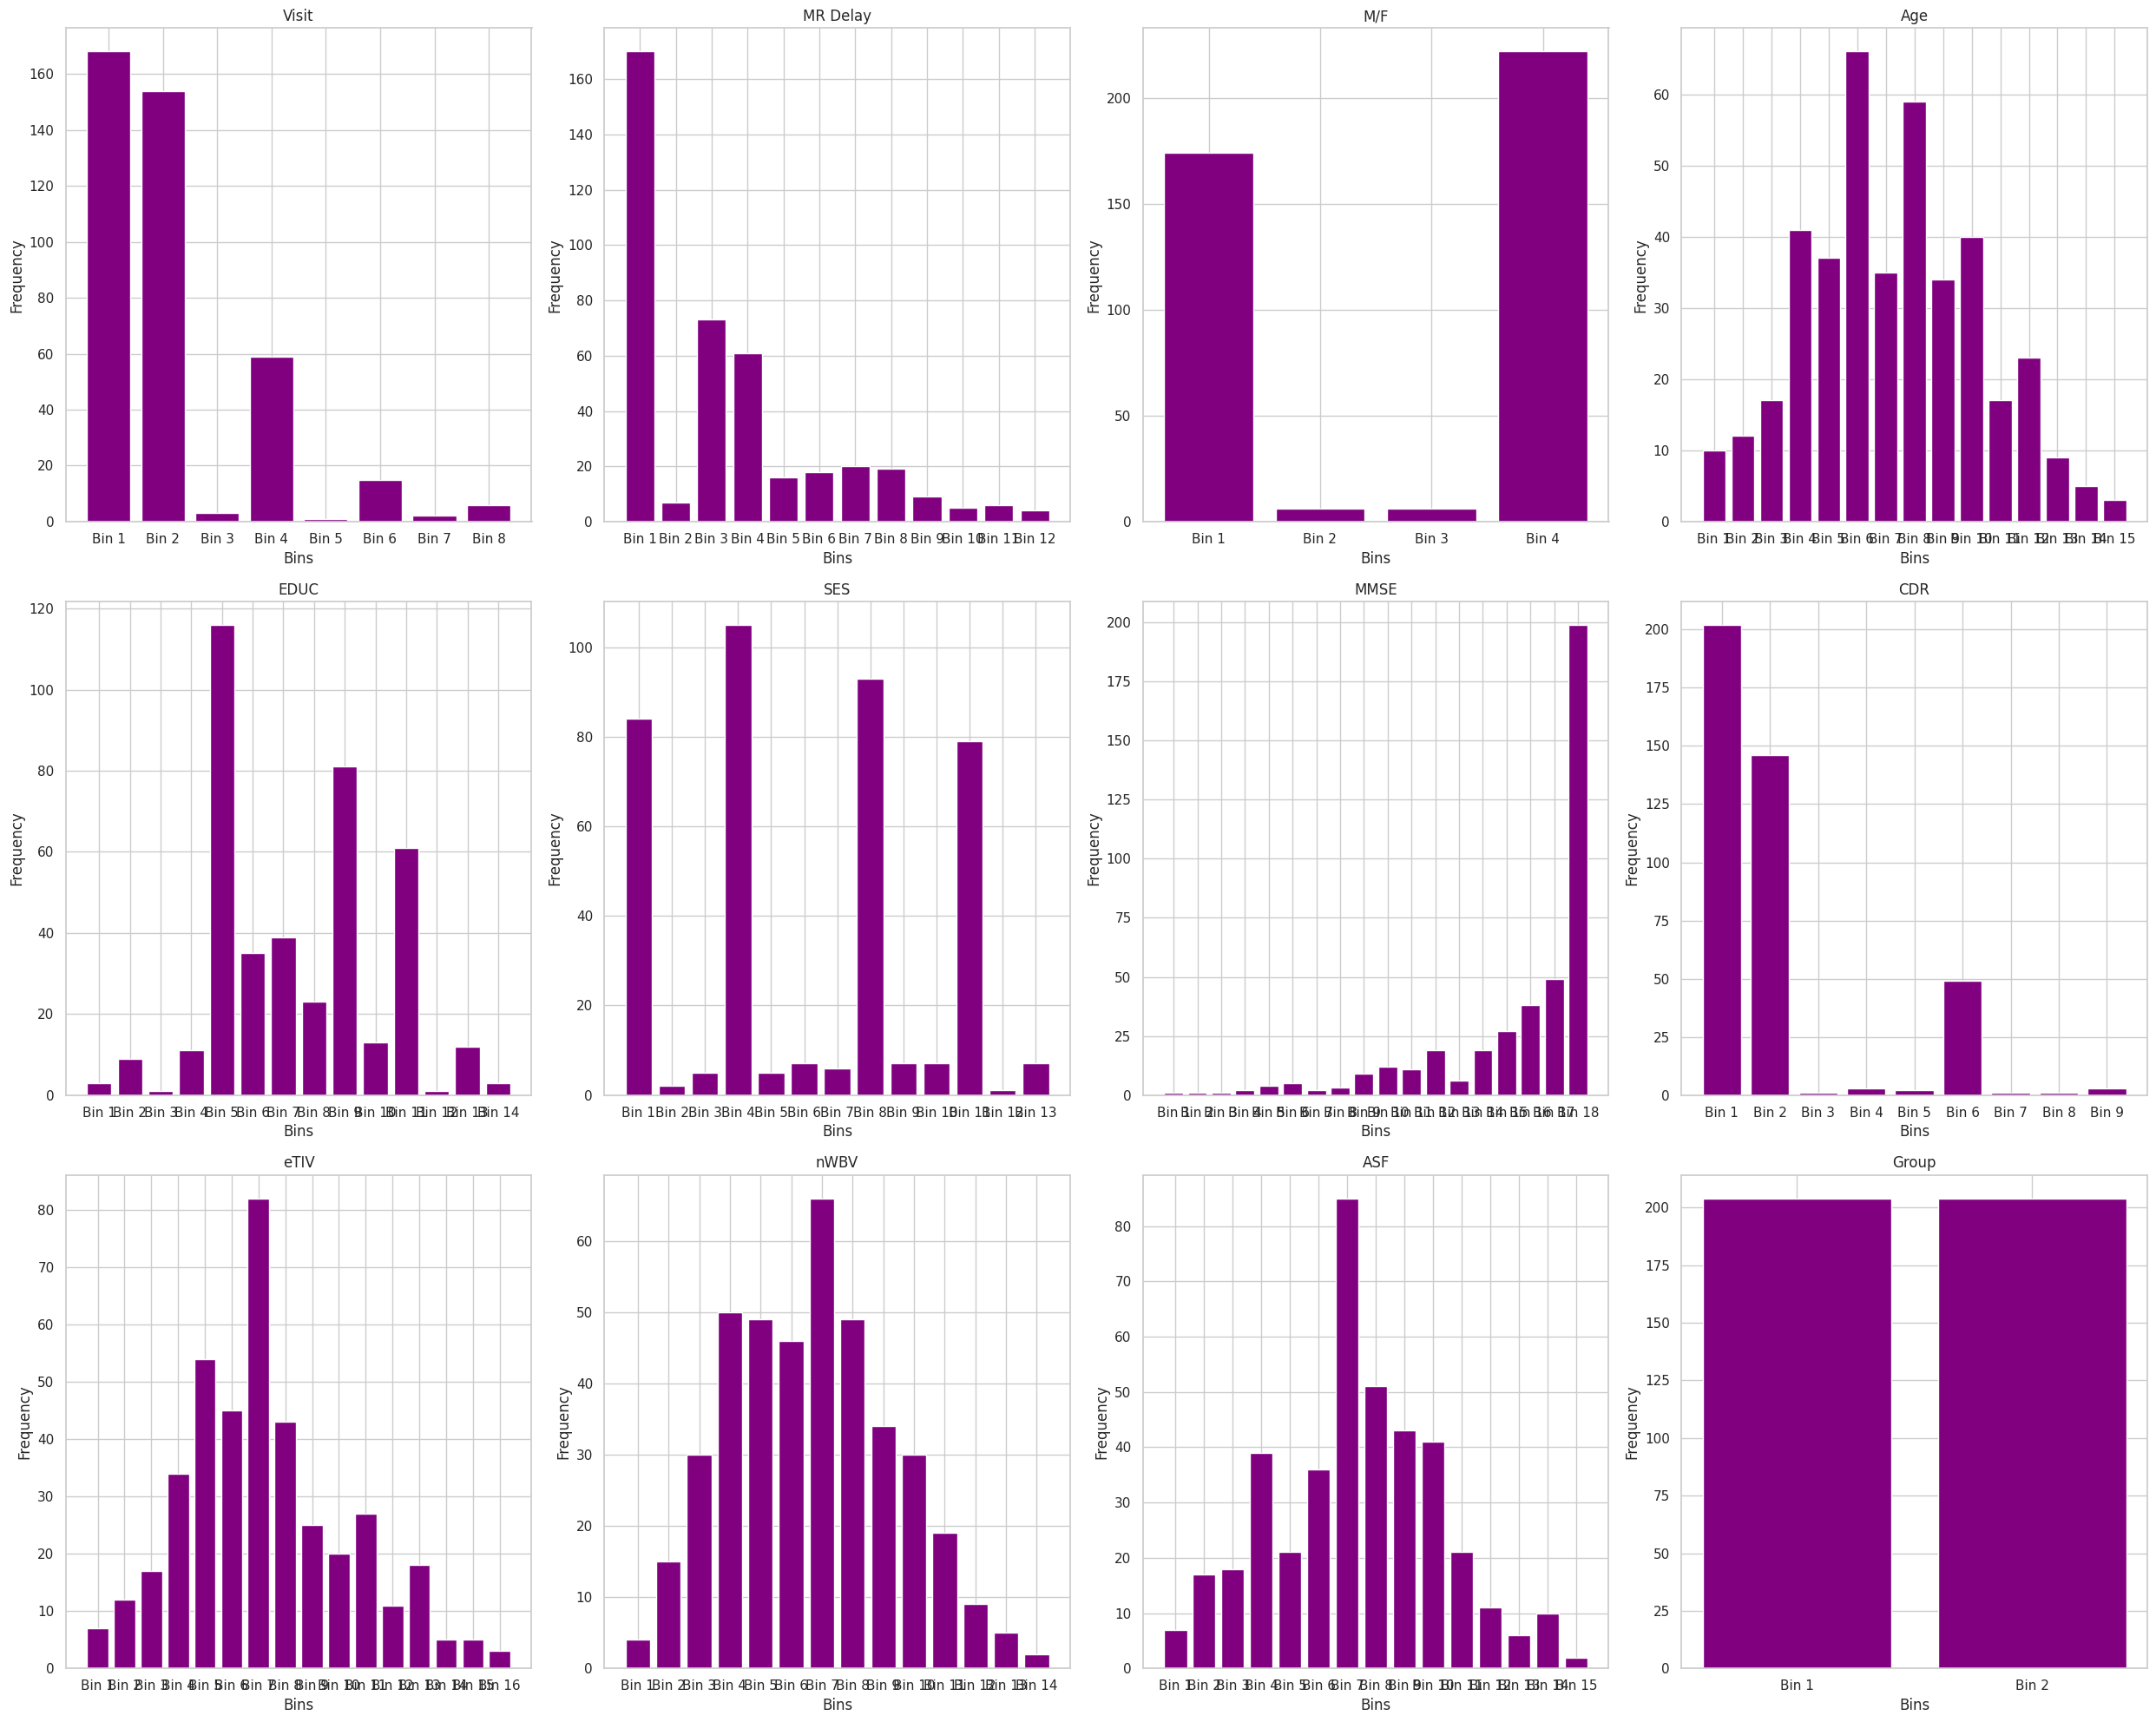

In [10]:
plot_bins_barcharts(dementia_df_freedman_diaconis)

### Comparing Discretisation Methods
---

Visually we can see that the Freedman-Diaconis Rule seemingly performs well compared to the other methods, without much extra computation needed. We can verify this by checking the Mean Squared Error (MSE) in comparison to the original, continuous data.

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
mse_5bins = mean_squared_error(dementia_df, dementia_df_5bins)
mse_sturges = mean_squared_error(dementia_df, dementia_df_sturges)
mse_freedman_diaconis = mean_squared_error(dementia_df, dementia_df_freedman_diaconis)

In [13]:
mse_values = [mse_5bins, mse_sturges, mse_freedman_diaconis]

Now we can visualise the MSE scores of each method (the lower the better).

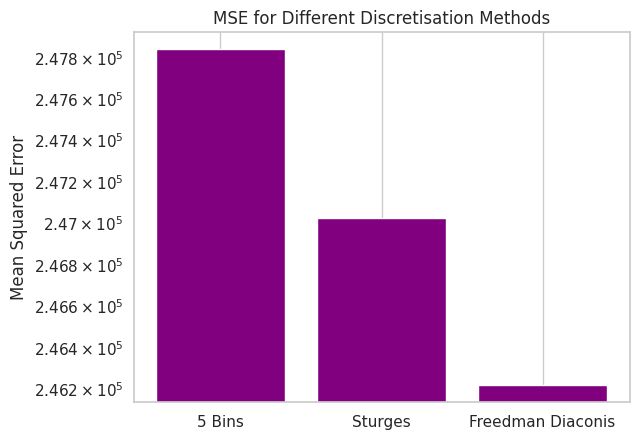

In [14]:
plt.bar(['5 Bins', 'Sturges', 'Freedman Diaconis'], mse_values)
plt.title('MSE for Different Discretisation Methods')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.show()

As observed, the Freedman-Diaconis method yields the best performance among the four discretisation methods. However, the significantly high MSE score suggests that discretising the data may not be the most effective approach for this dataset. This indicates that using discrete Bayesian Networks (BNs) could be introducing substantial information loss.

In [15]:
dementia_df = dementia_df_freedman_diaconis.copy()
dementia_df.describe().T

count       mean       std  min    25%   50%   75%   max
Visit     408.0   2.602941  2.769470  0.0   0.00   3.0   3.0  12.0
MR Delay  408.0   2.362745  2.711480  0.0   0.00   2.0   3.0  11.0
M/F       408.0   1.676471  1.471510  0.0   0.00   3.0   3.0   3.0
Age       408.0   6.225490  2.997646  0.0   4.00   6.0   8.0  14.0
EDUC      408.0   7.463235  2.757812  0.0   5.00   7.0   9.0  15.0
SES       408.0   5.313725  4.023837  0.0   3.00   5.0   7.0  14.0
MMSE      408.0  21.705882  3.569150  0.0  21.00  23.0  24.0  24.0
CDR       408.0   2.139706  2.614943  0.0   0.00   3.0   3.0  14.0
eTIV      408.0   6.247549  3.076421  0.0   4.00   6.0   8.0  15.0
nWBV      408.0   5.654412  2.671292  0.0   4.00   6.0   7.0  13.0
ASF       408.0   6.311275  2.904486  0.0   4.75   6.0   8.0  14.0
Group     408.0   0.500000  0.500614  0.0   0.00   0.5   1.0   1.0

## Learning Structure & Parameters with Cross-Validation
---

Now we will explore the process of structure learning and parameter learning for Bayesian Networks (BNs) using the provided dataset. We will evaluate multiple structure learning methods, perform parameter learning, and assess the results using cross-validation.

Our goals are:
1. To understand the structure of the data using various structure learning algorithms.
2. To learn the parameters of the best structure.
3. To evaluate the performance of each method through cross-validation.

The methods we will use:
1. Tree-Augmented Naive Bayes (TAN)
2. Hill Climbing (HC) with BDeu scoring
3. PC Algorithm

We will then evaluate each method's performance and compare the results.

### Cross-Validation
---

In utils we have defined a function for cross validation, and we can run for each different type of model we want to test to see which one gets the best results.

In [16]:
evaluation = {}

#### Tree-Augmented Naive Bayes
---

In [17]:
structure_kwargs_tan = {'methodtype': 'tan', 'class_node': 'Group'}

##### Bayes

In [18]:
evaluation_tan_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+----------------------+
| Group    | Group(0)            | Group(1)             |
+----------+---------------------+----------------------+
| eTIV(0)  | 0.04955290611028316 | 0.052290076335877865 |
+----------+---------------------+----------------------+
| eTIV(1)  | 0.05402384500745157 | 0.05381679389312977  |
+----------+---------------------+----------------------+
| eTIV(2)  | 0.05551415797317437 | 0.0583969465648855   |
+----------+---------------------+----------------------+
| eTIV(3)  | 0.06594634873323398 | 0.07213740458015268  |
+----------+---------------------+----------------------+
| eTIV(4)  | 0.0912816691505216  | 0.06603053435114503  |
+--------

100%|██████████| 1/1 [00:00<00:00, 398.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.60it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.53it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.47it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 370.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.83it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.41it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.58it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.91it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05037878787878788  | 0.049924924924924924 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.053409090909090906 | 0.05442942942942943  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.054924242424242424 | 0.057432432432432436 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06401515151515151  | 0.06644144144144144  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09128787878787879  | 0.07094594594594594 

100%|██████████| 1/1 [00:00<00:00, 478.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 723.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 700.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 697.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 363.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 369.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.71it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.22it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05127245508982036  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05726047904191617  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05726047904191617  | 0.05965045592705167  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06773952095808383  | 0.06724924012158055  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09169161676646706  | 0.06724924012158055 

100%|██████████| 1/1 [00:00<00:00, 450.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 741.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 666.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 700.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.97it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 747.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 332.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 651.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 359.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 359.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 689.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 723.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 732.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.27it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05015082956259427  | 0.05308734939759036  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.057692307692307696 | 0.05158132530120482  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.059200603318250375 | 0.05760542168674699  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06825037707390648  | 0.06814759036144578  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08484162895927602  | 0.07417168674698796 

100%|██████████| 1/1 [00:00<00:00, 580.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.42it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 337.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 355.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 164.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 226.58it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.052370030581039756 | 0.05089153046062407  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05542813455657492  | 0.05237741456166419  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05695718654434251  | 0.056835066864784546 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06613149847094801  | 0.07020802377414562  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08753822629969418  | 0.07169390787518573 

100%|██████████| 1/1 [00:00<00:00, 507.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.32it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 348.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 373.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 684.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 287.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 339.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.09it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 374.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 380.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.12it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 673.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 316.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.14it/s]


In [19]:
evaluation['Tree-Augmented Naive Bayes (Bayes)'] = evaluation_tan_bayes

##### Maximum Likelihood

In [20]:
evaluation_tan_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+-----------------------+
| Group    | Group(0)             | Group(1)              |
+----------+----------------------+-----------------------+
| eTIV(0)  | 0.011695906432748537 | 0.01935483870967742   |
+----------+----------------------+-----------------------+
| eTIV(1)  | 0.029239766081871343 | 0.025806451612903226  |
+----------+----------------------+-----------------------+
| eTIV(2)  | 0.03508771929824561  | 0.04516129032258064   |
+----------+----------------------+-----------------------+
| eTIV(3)  | 0.07602339181286549  | 0.1032258064516129    |
+----------+----------------------+-----------------------+
| eTIV(4)  | 0.17543859649122806  | 0.0774193548

100%|██████████| 1/1 [00:00<00:00, 522.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 279.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.03it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.80it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.28it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 292.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 367.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 352.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.58it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 333.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.16it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.05it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 367.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 753.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.88it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.012048192771084338 |
+----------+----------+----------------------+
| eTIV(1)  | 0.025    | 0.030120481927710843 |
+----------+----------+----------------------+
| eTIV(2)  | 0.03125  | 0.04216867469879518  |
+----------+----------+----------------------+
| eTIV(3)  | 0.06875  | 0.0783132530120482   |
+----------+----------+----------------------+
| eTIV(4)  | 0.18125  | 0.0963855421686747   |
+----------+----------+----------------------+
| eTIV(5)  | 0.075    | 0.12048192771084337  |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 413.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.64it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 666.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 701.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 346.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 765.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 350.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 718.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.36it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 326.10it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.017857142857142856 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.041666666666666664 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.041666666666666664 | 0.05063291139240506  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08333333333333333  | 0.08227848101265822  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.17857142857142858  | 0.08227848101265822  |


100%|██████████| 1/1 [00:00<00:00, 640.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.13it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 375.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 348.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 341.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.18it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012269938650306749 | 0.024390243902439025 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.04294478527607362  | 0.018292682926829267 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.049079754601226995 | 0.042682926829268296 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08588957055214724  | 0.08536585365853659  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.15337423312883436  | 0.10975609756097561  |


100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 750.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 728.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 725.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.80it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 375.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.25it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.01948051948051948  | 0.017341040462427744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.032467532467532464 | 0.023121387283236993 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.03896103896103896  | 0.04046242774566474  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.07792207792207792  | 0.09248554913294797  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.16883116883116883  | 0.09826589595375723  |


100%|██████████| 1/1 [00:00<00:00, 614.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 750.59it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 754.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 750.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 743.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 741.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 731.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 743.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.13it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 689.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.29it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 369.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 184.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.09it/s]


In [21]:
evaluation['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = evaluation_tan_ml

#### Hill Climbing
---

In [22]:
structure_kwargs_hc = {'methodtype': 'hc', 'scoretype': 'bdeu'}

##### Bayes

In [23]:
evaluation_hc_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+----------------------+
| Group    | Group(0)            | Group(1)             |
+----------+---------------------+----------------------+
| eTIV(0)  | 0.04955290611028316 | 0.052290076335877865 |
+----------+---------------------+----------------------+
| eTIV(1)  | 0.05402384500745157 | 0.05381679389312977  |
+----------+---------------------+----------------------+
| eTIV(2)  | 0.05551415797317437 | 0.0583969465648855   |
+----------+---------------------+----------------------+
| eTIV(3)  | 0.06594634873323398 | 0.07213740458015268  |
+----------+---------------------+----------------------+
| eTIV(4)  | 0.0912816691505216  | 0.06603053435114503  |
+--------

100%|██████████| 1/1 [00:00<00:00, 657.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.92it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.23it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 754.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.25it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.00it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.15it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.25it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.87it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05037878787878788  | 0.049924924924924924 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.053409090909090906 | 0.05442942942942943  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.054924242424242424 | 0.057432432432432436 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06401515151515151  | 0.06644144144144144  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09128787878787879  | 0.07094594594594594 

100%|██████████| 1/1 [00:00<00:00, 469.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 730.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.72it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 684.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 327.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.88it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.94it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05127245508982036  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05726047904191617  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05726047904191617  | 0.05965045592705167  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06773952095808383  | 0.06724924012158055  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09169161676646706  | 0.06724924012158055 

100%|██████████| 1/1 [00:00<00:00, 596.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 718.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.44it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 379.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 363.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 689.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 696.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 679.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.04it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05015082956259427  | 0.05308734939759036  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.057692307692307696 | 0.05158132530120482  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.059200603318250375 | 0.05760542168674699  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06825037707390648  | 0.06814759036144578  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08484162895927602  | 0.07417168674698796 

100%|██████████| 1/1 [00:00<00:00, 494.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.66it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 377.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.28it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 702.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 701.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 684.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.88it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.052370030581039756 | 0.05089153046062407  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05542813455657492  | 0.05237741456166419  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05695718654434251  | 0.056835066864784546 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06613149847094801  | 0.07020802377414562  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08753822629969418  | 0.07169390787518573 

100%|██████████| 1/1 [00:00<00:00, 493.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 666.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.57it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 725.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 319.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.64it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.19it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.87it/s]


In [24]:
evaluation['BDeu Hill Climbing (Bayes)'] = evaluation_hc_bayes

##### Maximum Likelihood

In [25]:
evaluation_hc_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+-----------------------+
| Group    | Group(0)             | Group(1)              |
+----------+----------------------+-----------------------+
| eTIV(0)  | 0.011695906432748537 | 0.01935483870967742   |
+----------+----------------------+-----------------------+
| eTIV(1)  | 0.029239766081871343 | 0.025806451612903226  |
+----------+----------------------+-----------------------+
| eTIV(2)  | 0.03508771929824561  | 0.04516129032258064   |
+----------+----------------------+-----------------------+
| eTIV(3)  | 0.07602339181286549  | 0.1032258064516129    |
+----------+----------------------+-----------------------+
| eTIV(4)  | 0.17543859649122806  | 0.0774193548

100%|██████████| 1/1 [00:00<00:00, 470.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.58it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 299.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.88it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 718.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.00it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.19it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.91it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 735.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 694.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 674.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.72it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.012048192771084338 |
+----------+----------+----------------------+
| eTIV(1)  | 0.025    | 0.030120481927710843 |
+----------+----------+----------------------+
| eTIV(2)  | 0.03125  | 0.04216867469879518  |
+----------+----------+----------------------+
| eTIV(3)  | 0.06875  | 0.0783132530120482   |
+----------+----------+----------------------+
| eTIV(4)  | 0.18125  | 0.0963855421686747   |
+----------+----------+----------------------+
| eTIV(5)  | 0.075    | 0.12048192771084337  |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 637.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 697.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.47it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 701.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 651.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.58it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 737.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.62it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.017857142857142856 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.041666666666666664 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.041666666666666664 | 0.05063291139240506  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08333333333333333  | 0.08227848101265822  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.17857142857142858  | 0.08227848101265822  |


100%|██████████| 1/1 [00:00<00:00, 534.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 343.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.44it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 740.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 743.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.04it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 402.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 666.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.99it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012269938650306749 | 0.024390243902439025 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.04294478527607362  | 0.018292682926829267 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.049079754601226995 | 0.042682926829268296 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08588957055214724  | 0.08536585365853659  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.15337423312883436  | 0.10975609756097561  |


100%|██████████| 1/1 [00:00<00:00, 484.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 679.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 696.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 701.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.21it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.78it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 307.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.53it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.01948051948051948  | 0.017341040462427744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.032467532467532464 | 0.023121387283236993 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.03896103896103896  | 0.04046242774566474  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.07792207792207792  | 0.09248554913294797  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.16883116883116883  | 0.09826589595375723  |


100%|██████████| 1/1 [00:00<00:00, 503.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.64it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 694.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.69it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 730.21it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.08it/s]


In [26]:
evaluation['BDeu Hill Climbing (Maximum Likelihood)'] = evaluation_hc_ml

#### PC Algorithm
---

In [27]:
structure_kwargs_pc = {'methodtype': 'pc'}

##### Bayes

In [28]:
evaluation_pc_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+----------------------+
| Group    | Group(0)            | Group(1)             |
+----------+---------------------+----------------------+
| eTIV(0)  | 0.04955290611028316 | 0.052290076335877865 |
+----------+---------------------+----------------------+
| eTIV(1)  | 0.05402384500745157 | 0.05381679389312977  |
+----------+---------------------+----------------------+
| eTIV(2)  | 0.05551415797317437 | 0.0583969465648855   |
+----------+---------------------+----------------------+
| eTIV(3)  | 0.06594634873323398 | 0.07213740458015268  |
+----------+---------------------+----------------------+
| eTIV(4)  | 0.0912816691505216  | 0.06603053435114503  |
+--------

100%|██████████| 1/1 [00:00<00:00, 579.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.82it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 689.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.91it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.87it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 752.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 748.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.84it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.62it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.16it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.39it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05037878787878788  | 0.049924924924924924 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.053409090909090906 | 0.05442942942942943  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.054924242424242424 | 0.057432432432432436 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06401515151515151  | 0.06644144144144144  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09128787878787879  | 0.07094594594594594 

100%|██████████| 1/1 [00:00<00:00, 637.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.29it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 680.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 718.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.46it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 369.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 370.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.46it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 620.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.49it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05127245508982036  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05726047904191617  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05726047904191617  | 0.05965045592705167  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06773952095808383  | 0.06724924012158055  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09169161676646706  | 0.06724924012158055 

100%|██████████| 1/1 [00:00<00:00, 461.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.36it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 332.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 348.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 323.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 701.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 365.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.69it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05015082956259427  | 0.05308734939759036  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.057692307692307696 | 0.05158132530120482  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.059200603318250375 | 0.05760542168674699  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06825037707390648  | 0.06814759036144578  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08484162895927602  | 0.07417168674698796 

100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.69it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 651.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 684.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 320.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.38it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.052370030581039756 | 0.05089153046062407  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05542813455657492  | 0.05237741456166419  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05695718654434251  | 0.056835066864784546 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06613149847094801  | 0.07020802377414562  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08753822629969418  | 0.07169390787518573 

100%|██████████| 1/1 [00:00<00:00, 581.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.54it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 320.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 259.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 375.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.64it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.84it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.70it/s]


In [29]:
evaluation['PC Algorithm (Bayes)'] = evaluation_pc_bayes

##### Maximum Likelihood

In [30]:
evaluation_pc_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+-----------------------+
| Group    | Group(0)             | Group(1)              |
+----------+----------------------+-----------------------+
| eTIV(0)  | 0.011695906432748537 | 0.01935483870967742   |
+----------+----------------------+-----------------------+
| eTIV(1)  | 0.029239766081871343 | 0.025806451612903226  |
+----------+----------------------+-----------------------+
| eTIV(2)  | 0.03508771929824561  | 0.04516129032258064   |
+----------+----------------------+-----------------------+
| eTIV(3)  | 0.07602339181286549  | 0.1032258064516129    |
+----------+----------------------+-----------------------+
| eTIV(4)  | 0.17543859649122806  | 0.0774193548

100%|██████████| 1/1 [00:00<00:00, 580.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 330.81it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.83it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 728.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 696.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 740.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 259.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 308.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.92it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 305.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.41it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.92it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 680.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.50it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.46it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.012048192771084338 |
+----------+----------+----------------------+
| eTIV(1)  | 0.025    | 0.030120481927710843 |
+----------+----------+----------------------+
| eTIV(2)  | 0.03125  | 0.04216867469879518  |
+----------+----------+----------------------+
| eTIV(3)  | 0.06875  | 0.0783132530120482   |
+----------+----------+----------------------+
| eTIV(4)  | 0.18125  | 0.0963855421686747   |
+----------+----------+----------------------+
| eTIV(5)  | 0.075    | 0.12048192771084337  |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 484.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.46it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 241.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.46it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 499.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 338.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 673.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.97it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 248.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 187.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.38it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.017857142857142856 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.041666666666666664 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.041666666666666664 | 0.05063291139240506  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08333333333333333  | 0.08227848101265822  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.17857142857142858  | 0.08227848101265822  |


100%|██████████| 1/1 [00:00<00:00, 682.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 363.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.31it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.61it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 677.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.54it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.64it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012269938650306749 | 0.024390243902439025 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.04294478527607362  | 0.018292682926829267 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.049079754601226995 | 0.042682926829268296 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08588957055214724  | 0.08536585365853659  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.15337423312883436  | 0.10975609756097561  |


100%|██████████| 1/1 [00:00<00:00, 581.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.30it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 726.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 326.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.76it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 582.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 723.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.58it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.01948051948051948  | 0.017341040462427744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.032467532467532464 | 0.023121387283236993 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.03896103896103896  | 0.04046242774566474  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.07792207792207792  | 0.09248554913294797  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.16883116883116883  | 0.09826589595375723  |


100%|██████████| 1/1 [00:00<00:00, 634.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.14it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 367.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.02it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 709.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 738.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.00it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 377.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.44it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 581.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.68it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.73it/s]


In [31]:
evaluation['PC Algorithm (Maximum Likelihood)'] = evaluation_pc_ml

### Evaluation
---

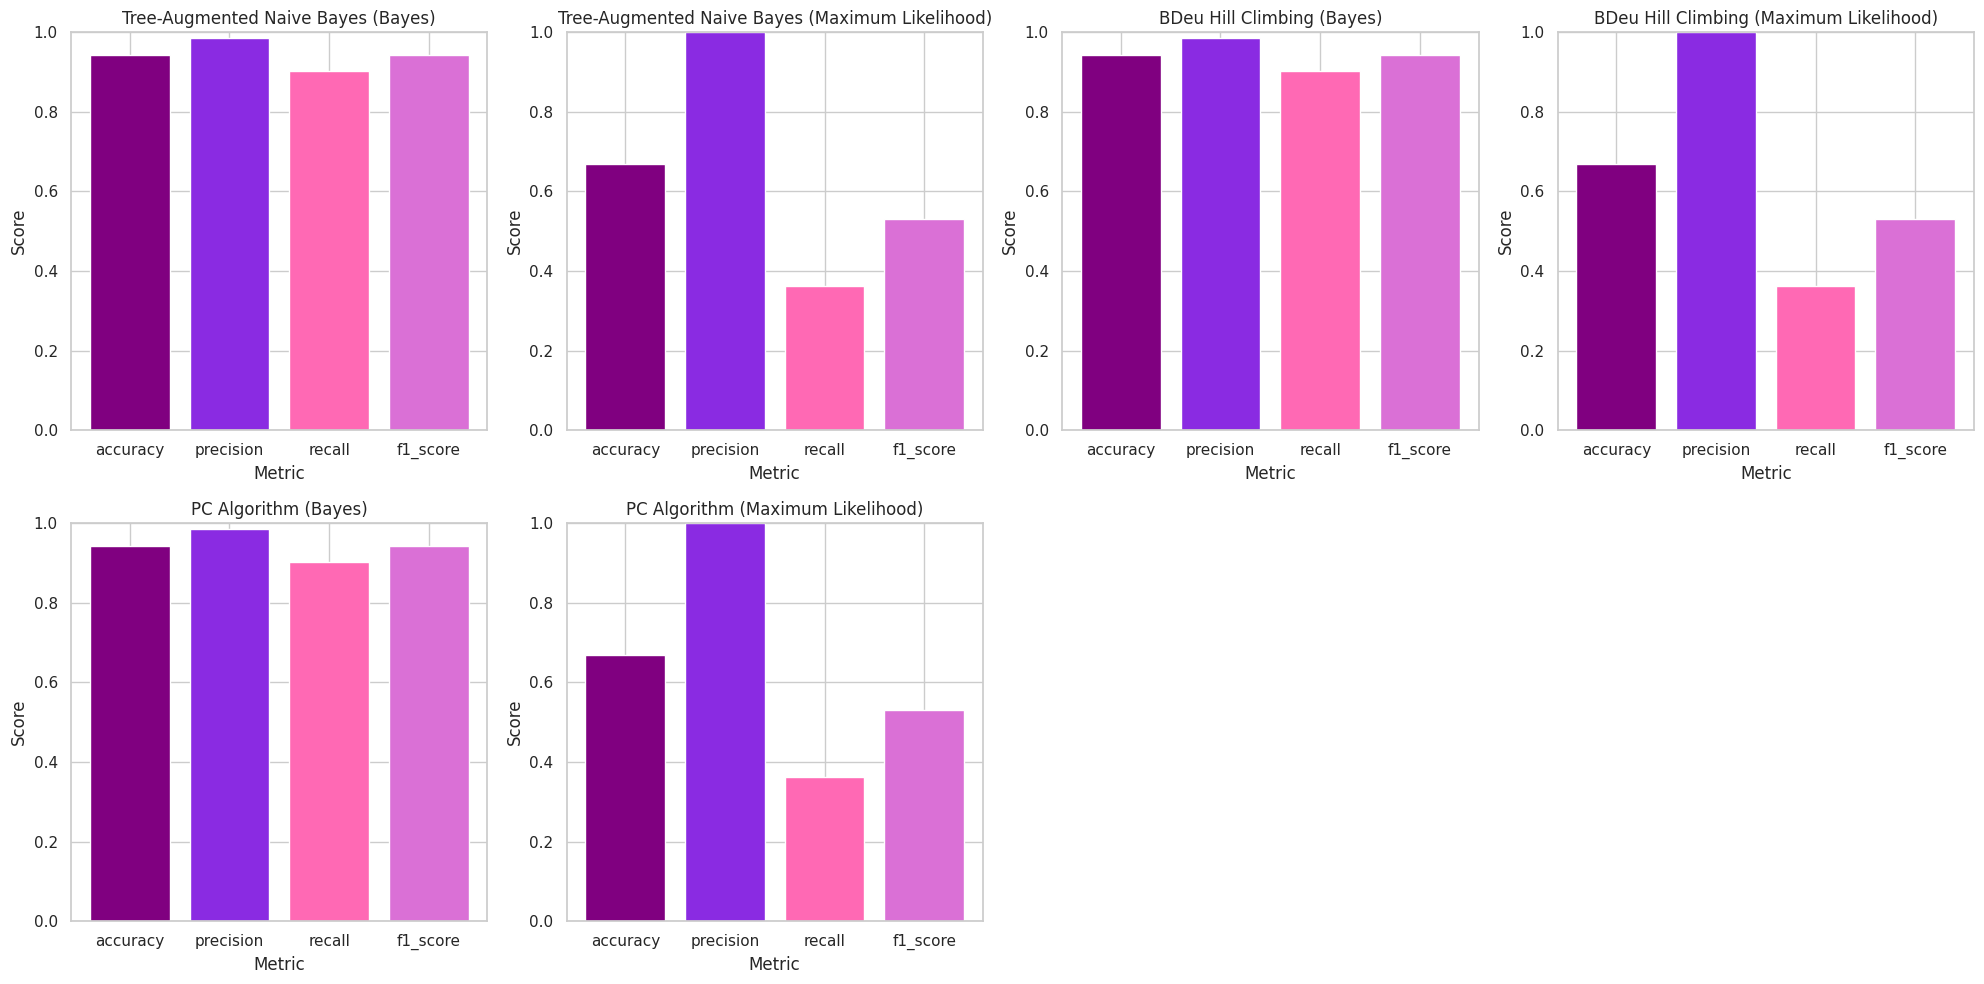

In [32]:
plot_metrics_from_evaluation(evaluation)

In [33]:
display_evaluation_results(evaluation)


Tree-Augmented Naive Bayes (Bayes):
  Metrics:
    Classification:
      Accuracy: 94.24%
      Precision: 98.47%
      Recall: 90.35%
      F1_score: 94.22%
    Roc_auc: 0.9443587278881223
    Brier_score: 0.05755558199680625
    Log_loss: 2.0745134481017957
  Time Taken: 39.26 seconds
  Confusion Matrix: [201   3]
                    [ 17 174]

Tree-Augmented Naive Bayes (Maximum Likelihood):
  Metrics:
    Classification:
      Accuracy: 66.84%
      Precision: 100.00%
      Recall: 36.15%
      F1_score: 53.07%
    Roc_auc: 0.6807322746687318
    Brier_score: 0.3315589251265152
    Log_loss: 11.950594975328361
  Time Taken: 6.14 seconds
  Confusion Matrix: [204   0]
                    [120  71]

BDeu Hill Climbing (Bayes):
  Metrics:
    Classification:
      Accuracy: 94.24%
      Precision: 98.47%
      Recall: 90.35%
      F1_score: 94.22%
    Roc_auc: 0.9443587278881223
    Brier_score: 0.05755558199680625
    Log_loss: 2.0745134481017957
  Time Taken: 37.92 seconds
  Confusi

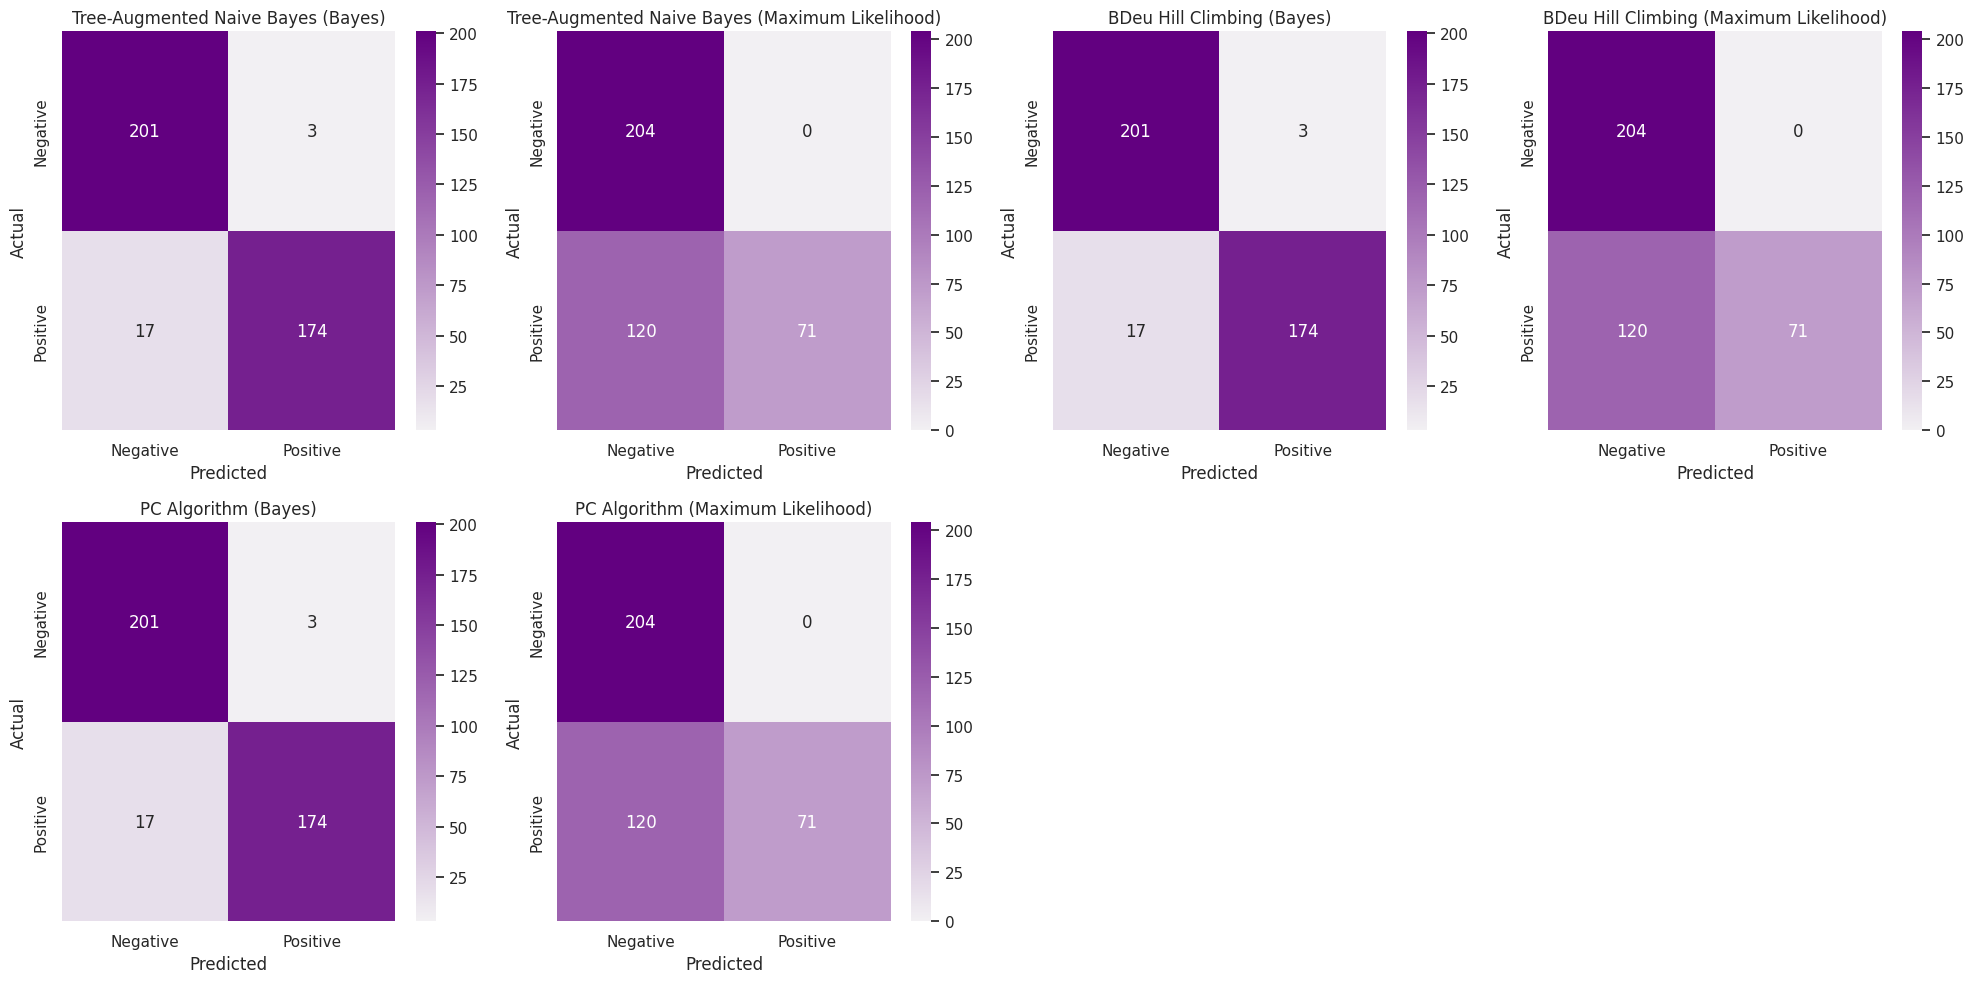

In [34]:
plot_confusion_matrices_from_evaluation(evaluation, cmap=gradient_palette)

# Parkinson's Disease
---

In [35]:
parkinsons_df = pd.read_csv('data/parkinsons_data_processed.csv')

## Discretising the Data
---

In [36]:
parkinsons_df_5bins = discretise(parkinsons_df.copy(), nbins=5)
parkinsons_df_sturges = discretise(parkinsons_df.copy(), method='sturges')
parkinsons_df_freedman_diaconis = discretise(parkinsons_df.copy(), method='freedman-diaconis')

### 5 Bin
---

In [37]:
parkinsons_df_5bins.head()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0            0             4             0               0                 0   
1            0             0             0               0                 1   
2            1             1             0               0                 0   
3            1             0             0               1                 1   
4            0             0             0               0                 0   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0         0         0           0             0                 0  ...   
1         0         0           0             1                 0  ...   
2         0         0           0             1                 1  ...   
3         1         0           1             0                 0  ...   
4         0         0           0             0                 0  ...   

   Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  spread2  D2  PPE  Status  
0            0    0    3     3    1        1        1   1    0       0  
1            1    0    2     4    4        2        2   1    2       1  
2            2    0    2     3    3        2        1   1    1       1  
3            1    0    2     4    1        2        3   3    2       1  
4            0    0    3     2    2        2        2   2    1       1  

[5 rows x 23 columns]

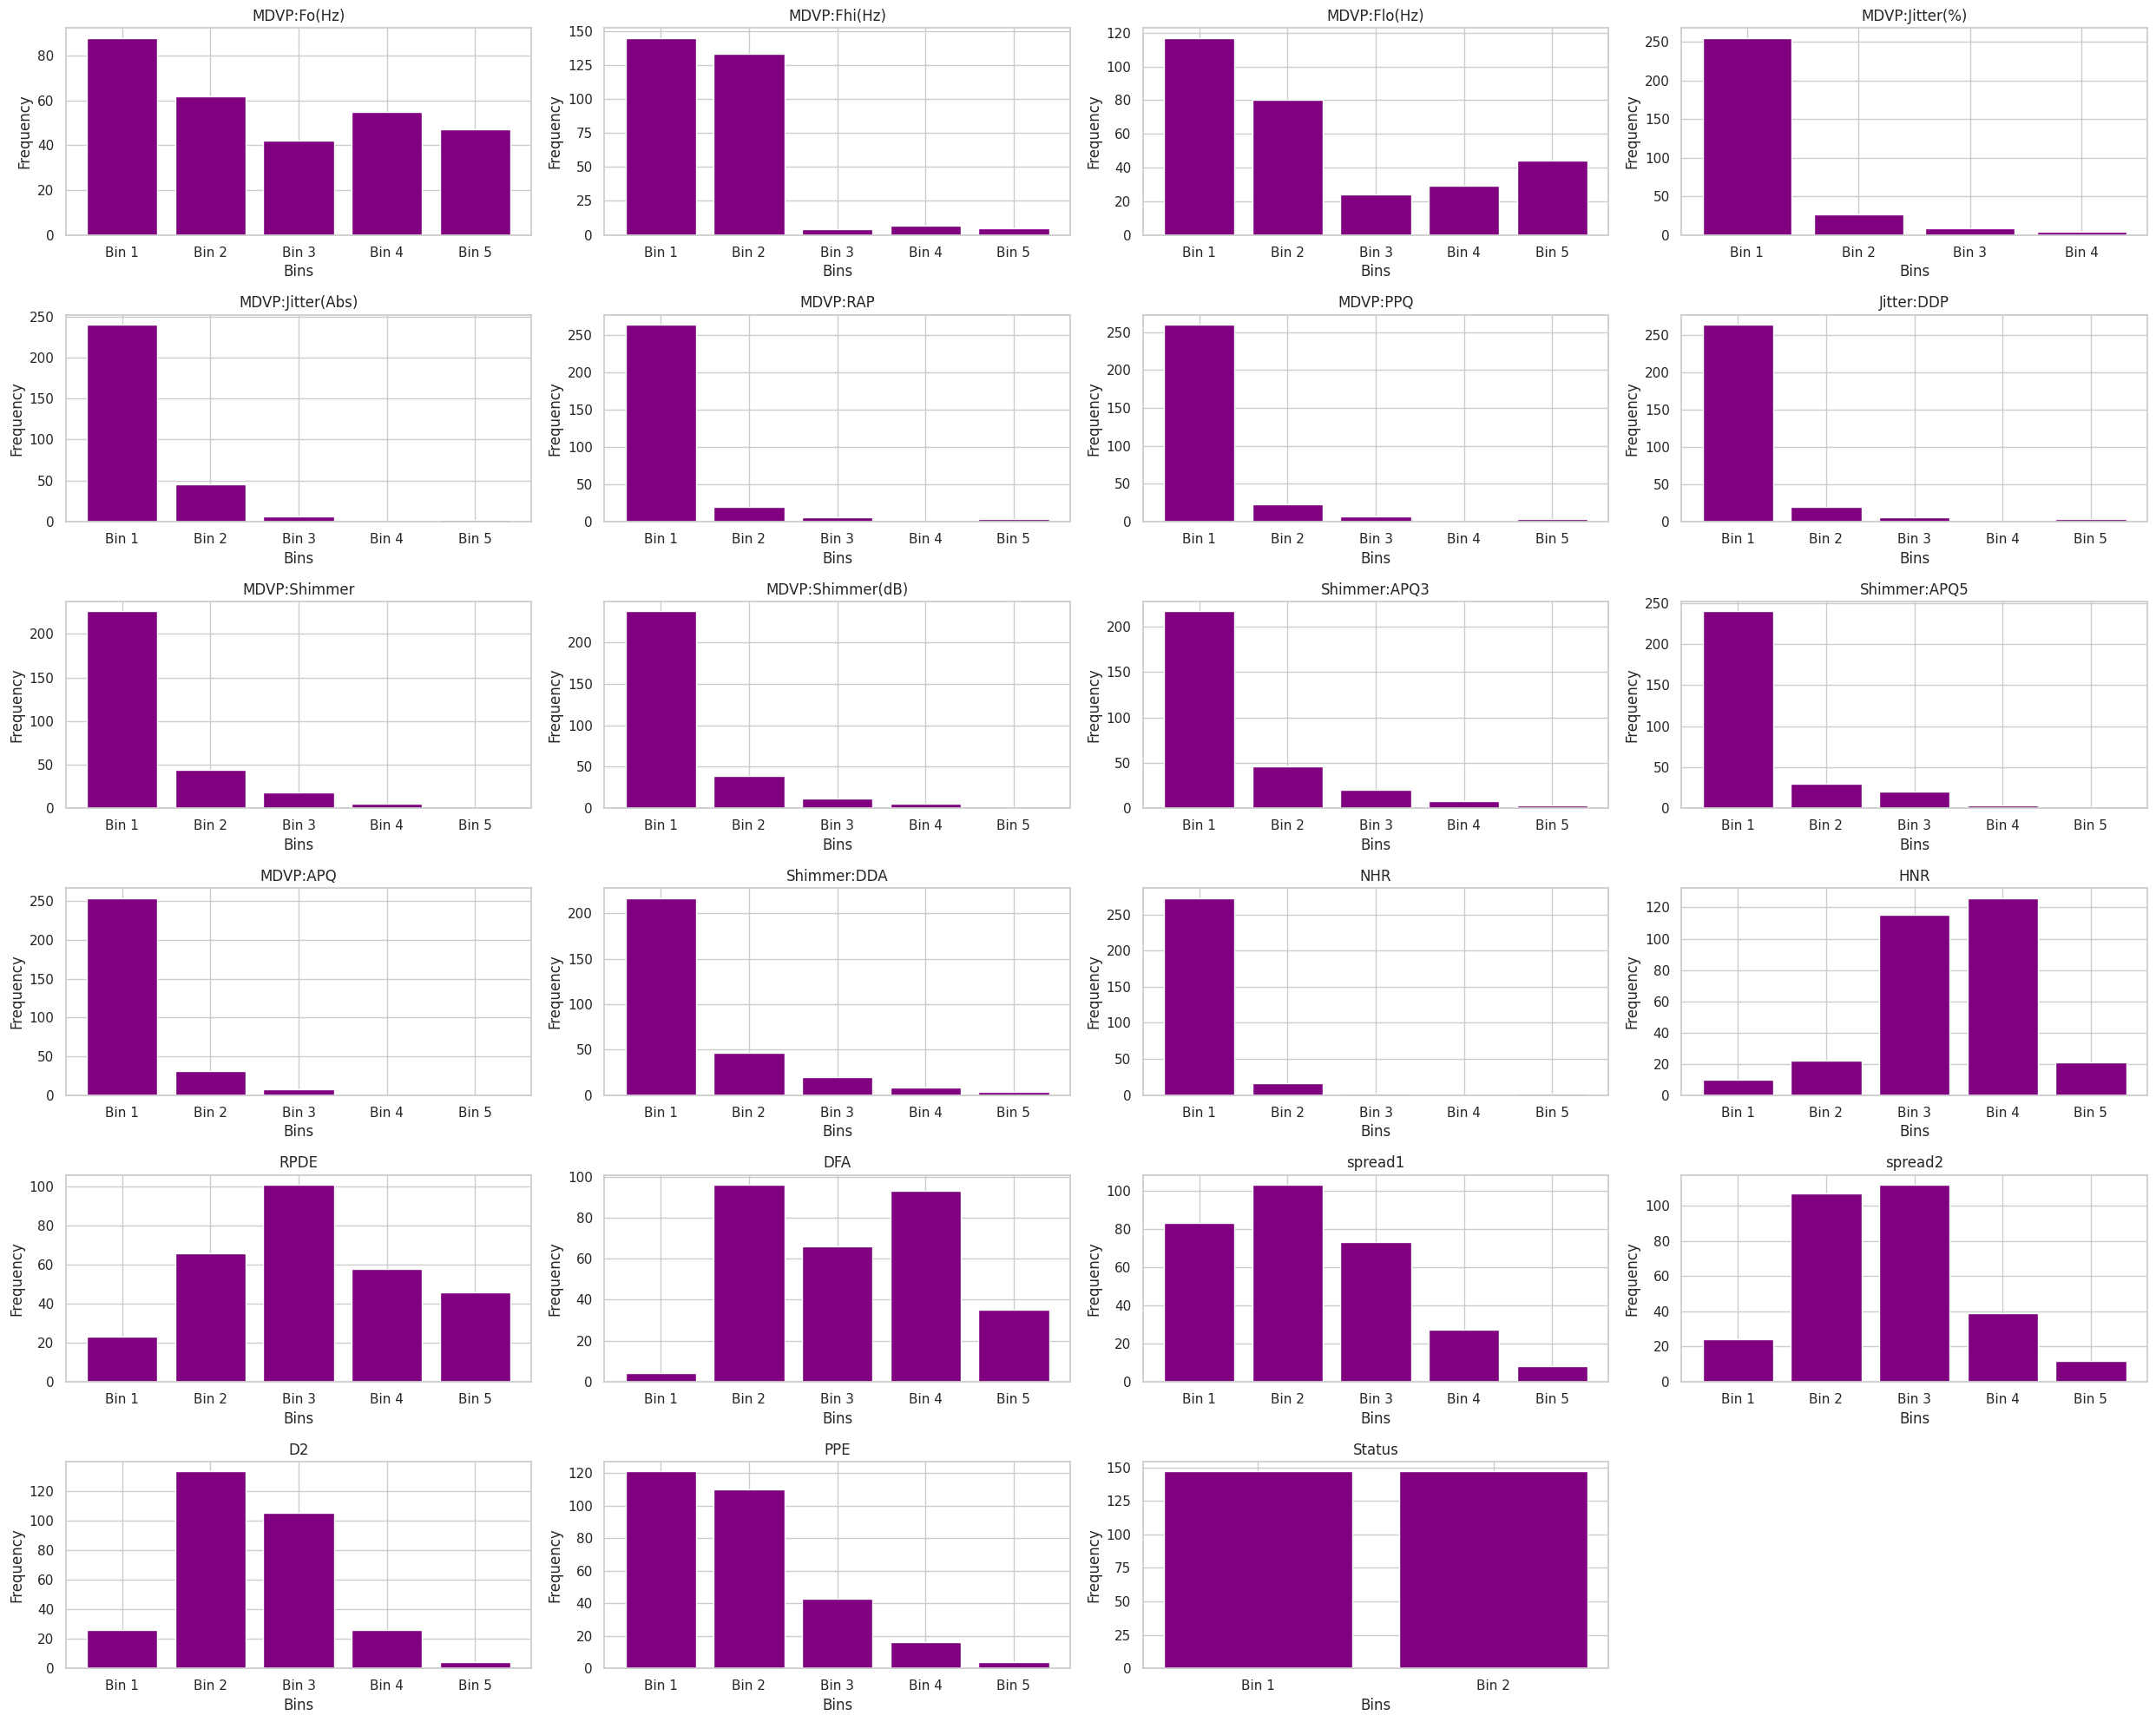

In [38]:
plot_bins_barcharts(parkinsons_df_5bins)

### Sturges
---

In [39]:
parkinsons_df_sturges.head()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0            1             9             1               1                 1   
1            0             0             1               1                 2   
2            2             2             1               1                 1   
3            2             1             1               2                 2   
4            1             0             1               0                 0   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0         0         0           0             0                 0  ...   
1         1         1           1             2                 1  ...   
2         1         1           1             3                 2  ...   
3         2         1           2             1                 1  ...   
4         0         0           0             0                 0  ...   

   Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  spread2  D2  PPE  Status  
0            0    0    6     7    3        2        3   3    1       0  
1            2    0    5     9    8        5        5   2    4       1  
2            4    0    4     6    6        4        3   2    3       1  
3            2    1    5     8    2        5        6   6    4       1  
4            0    0    6     5    5        4        5   4    3       1  

[5 rows x 23 columns]

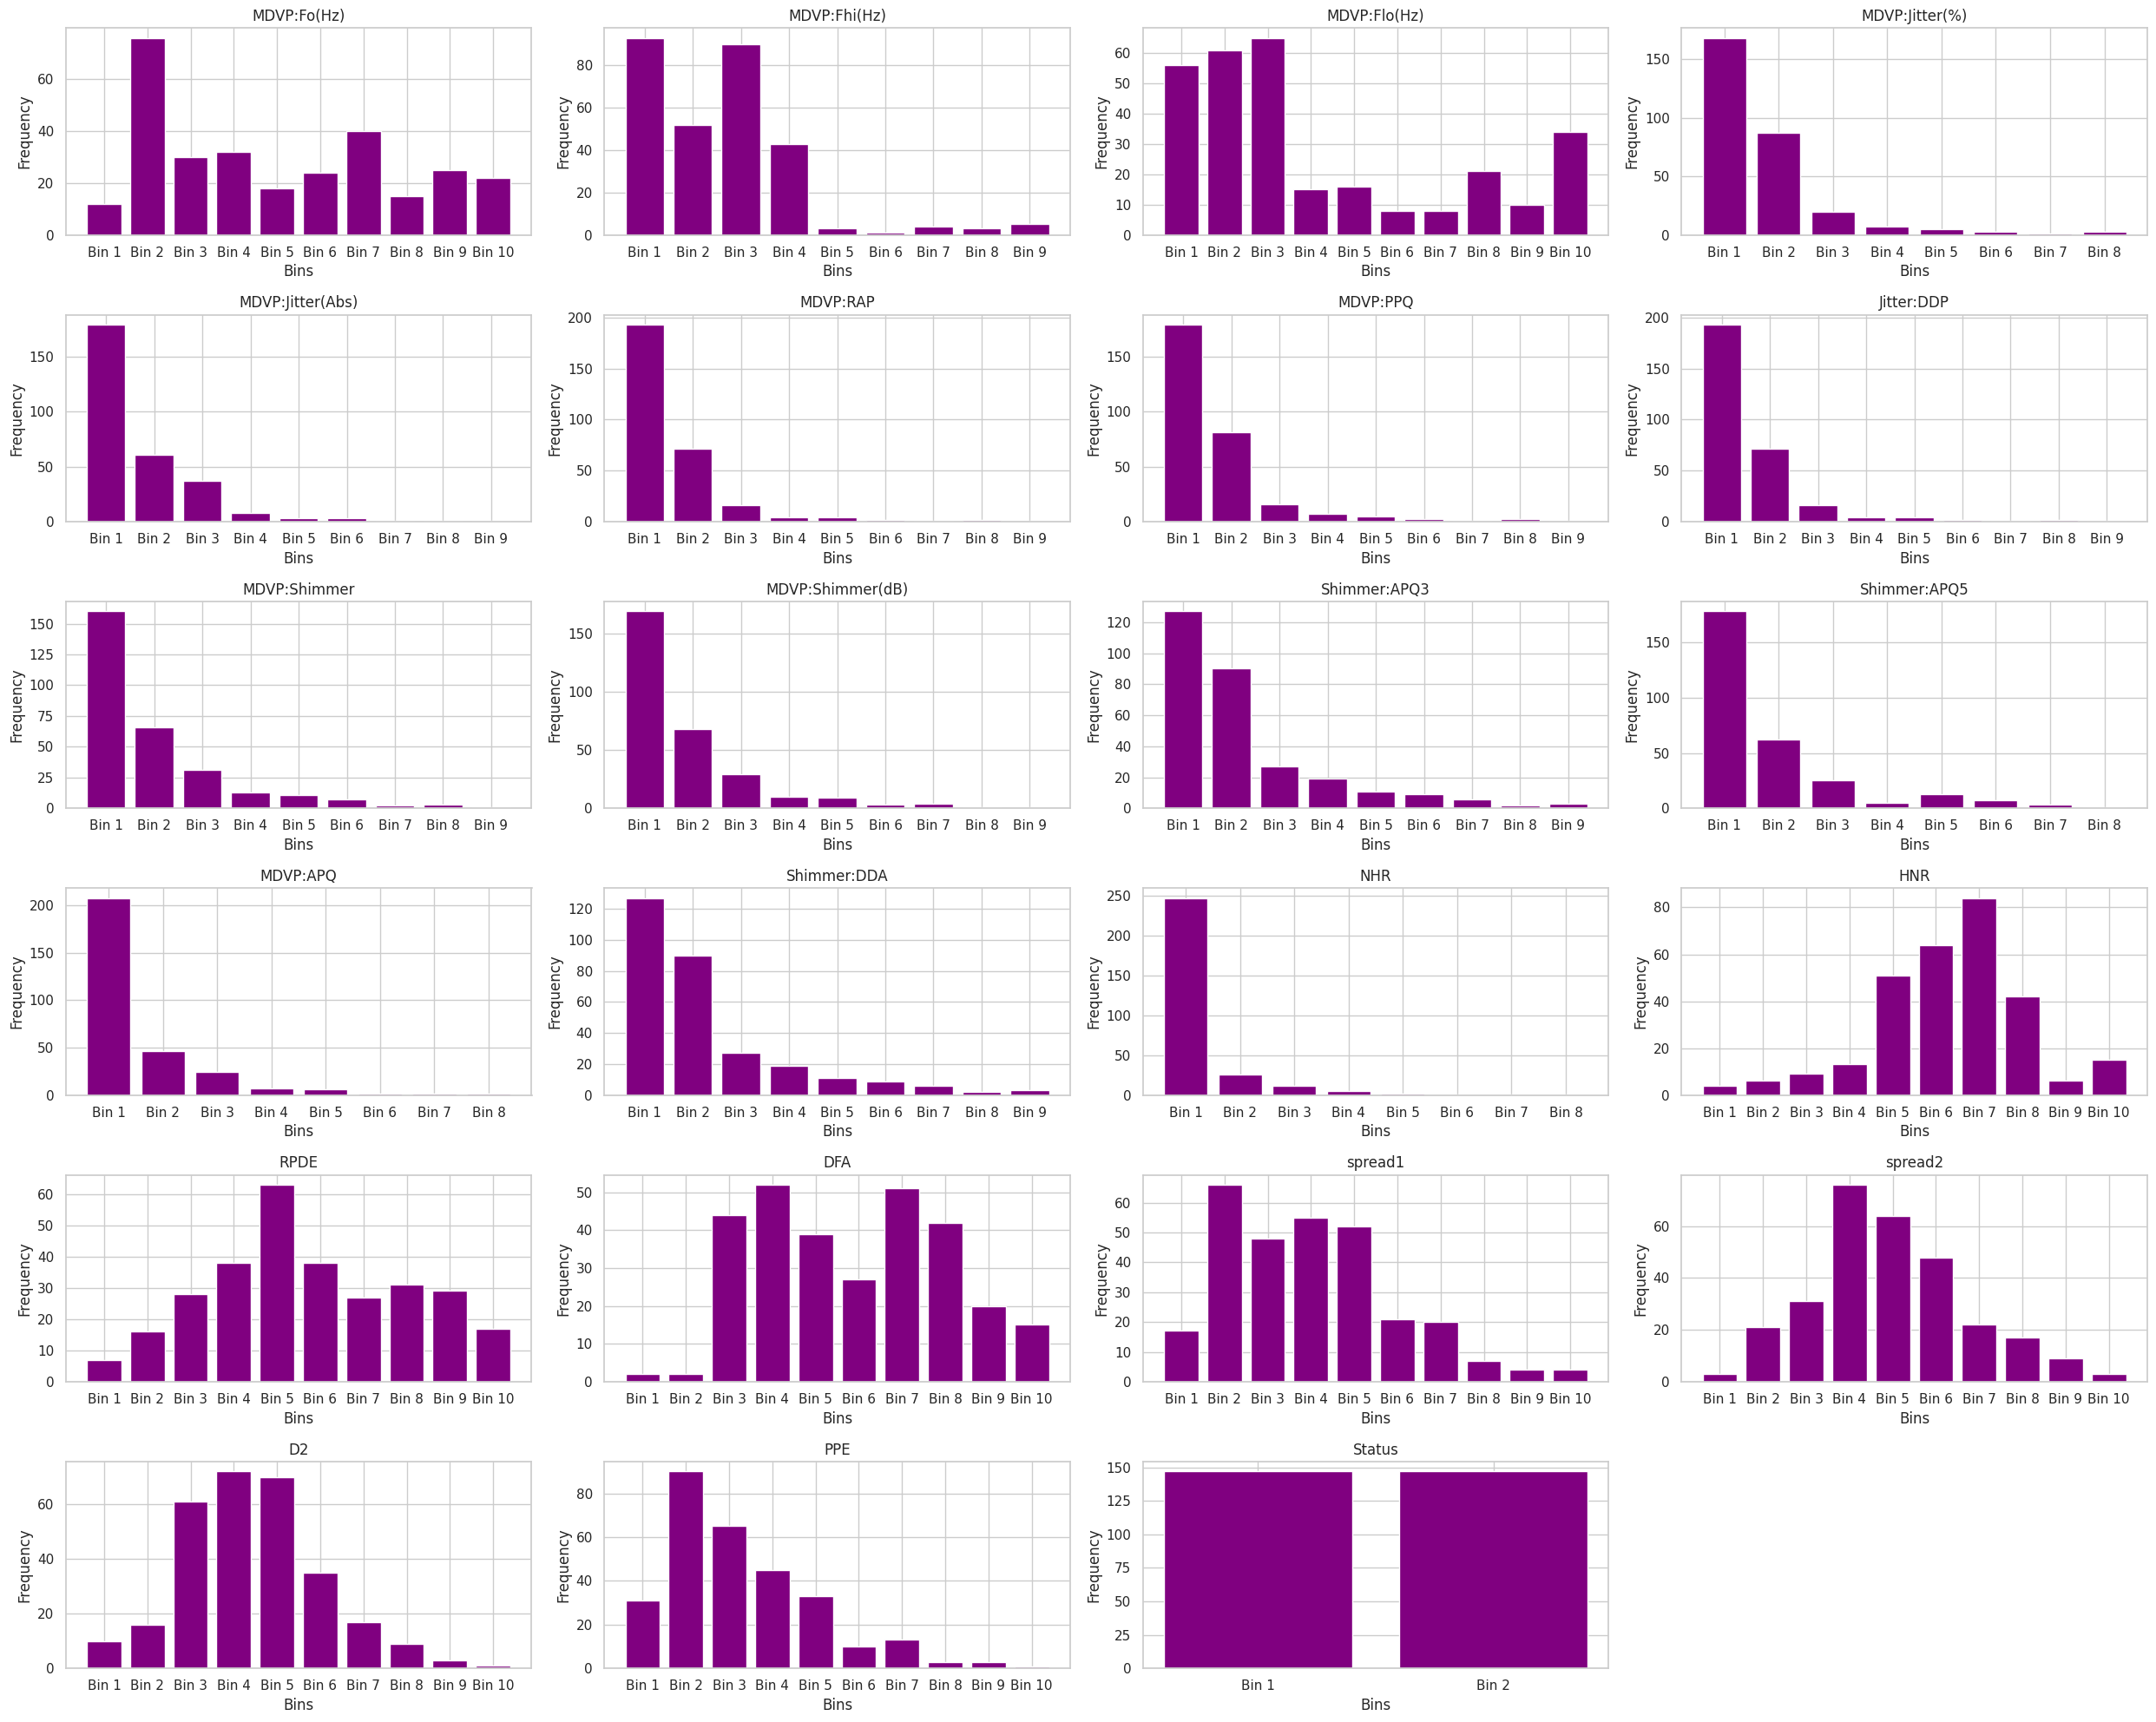

In [40]:
plot_bins_barcharts(parkinsons_df_sturges)

### Freedman Diaconis
---

In [41]:
parkinsons_df_freedman_diaconis.head()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0            1            15             0               3                 3   
1            0             0             1               4                 6   
2            2             3             0               5                 4   
3            1             1             1               8                 8   
4            1             0             0               1                 2   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0         3         3           3             1                 1  ...   
1         4         4           4             5                 4  ...   
2         6         5           6             8                 9  ...   
3         9         6           9             4                 4  ...   
4         1         1           1             0                 0  ...   

   Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  spread2  D2  PPE  Status  
0            1    2   10     7    3        3        4   5    2       0  
1            5    2    9     9    7        6        8   4    6       1  
2            9    4    6     6    5        5        5   5    5       1  
3            4    8    9     8    1        6        9  11    5       1  
4            0    1   10     5    5        5        8   8    5       1  

[5 rows x 23 columns]

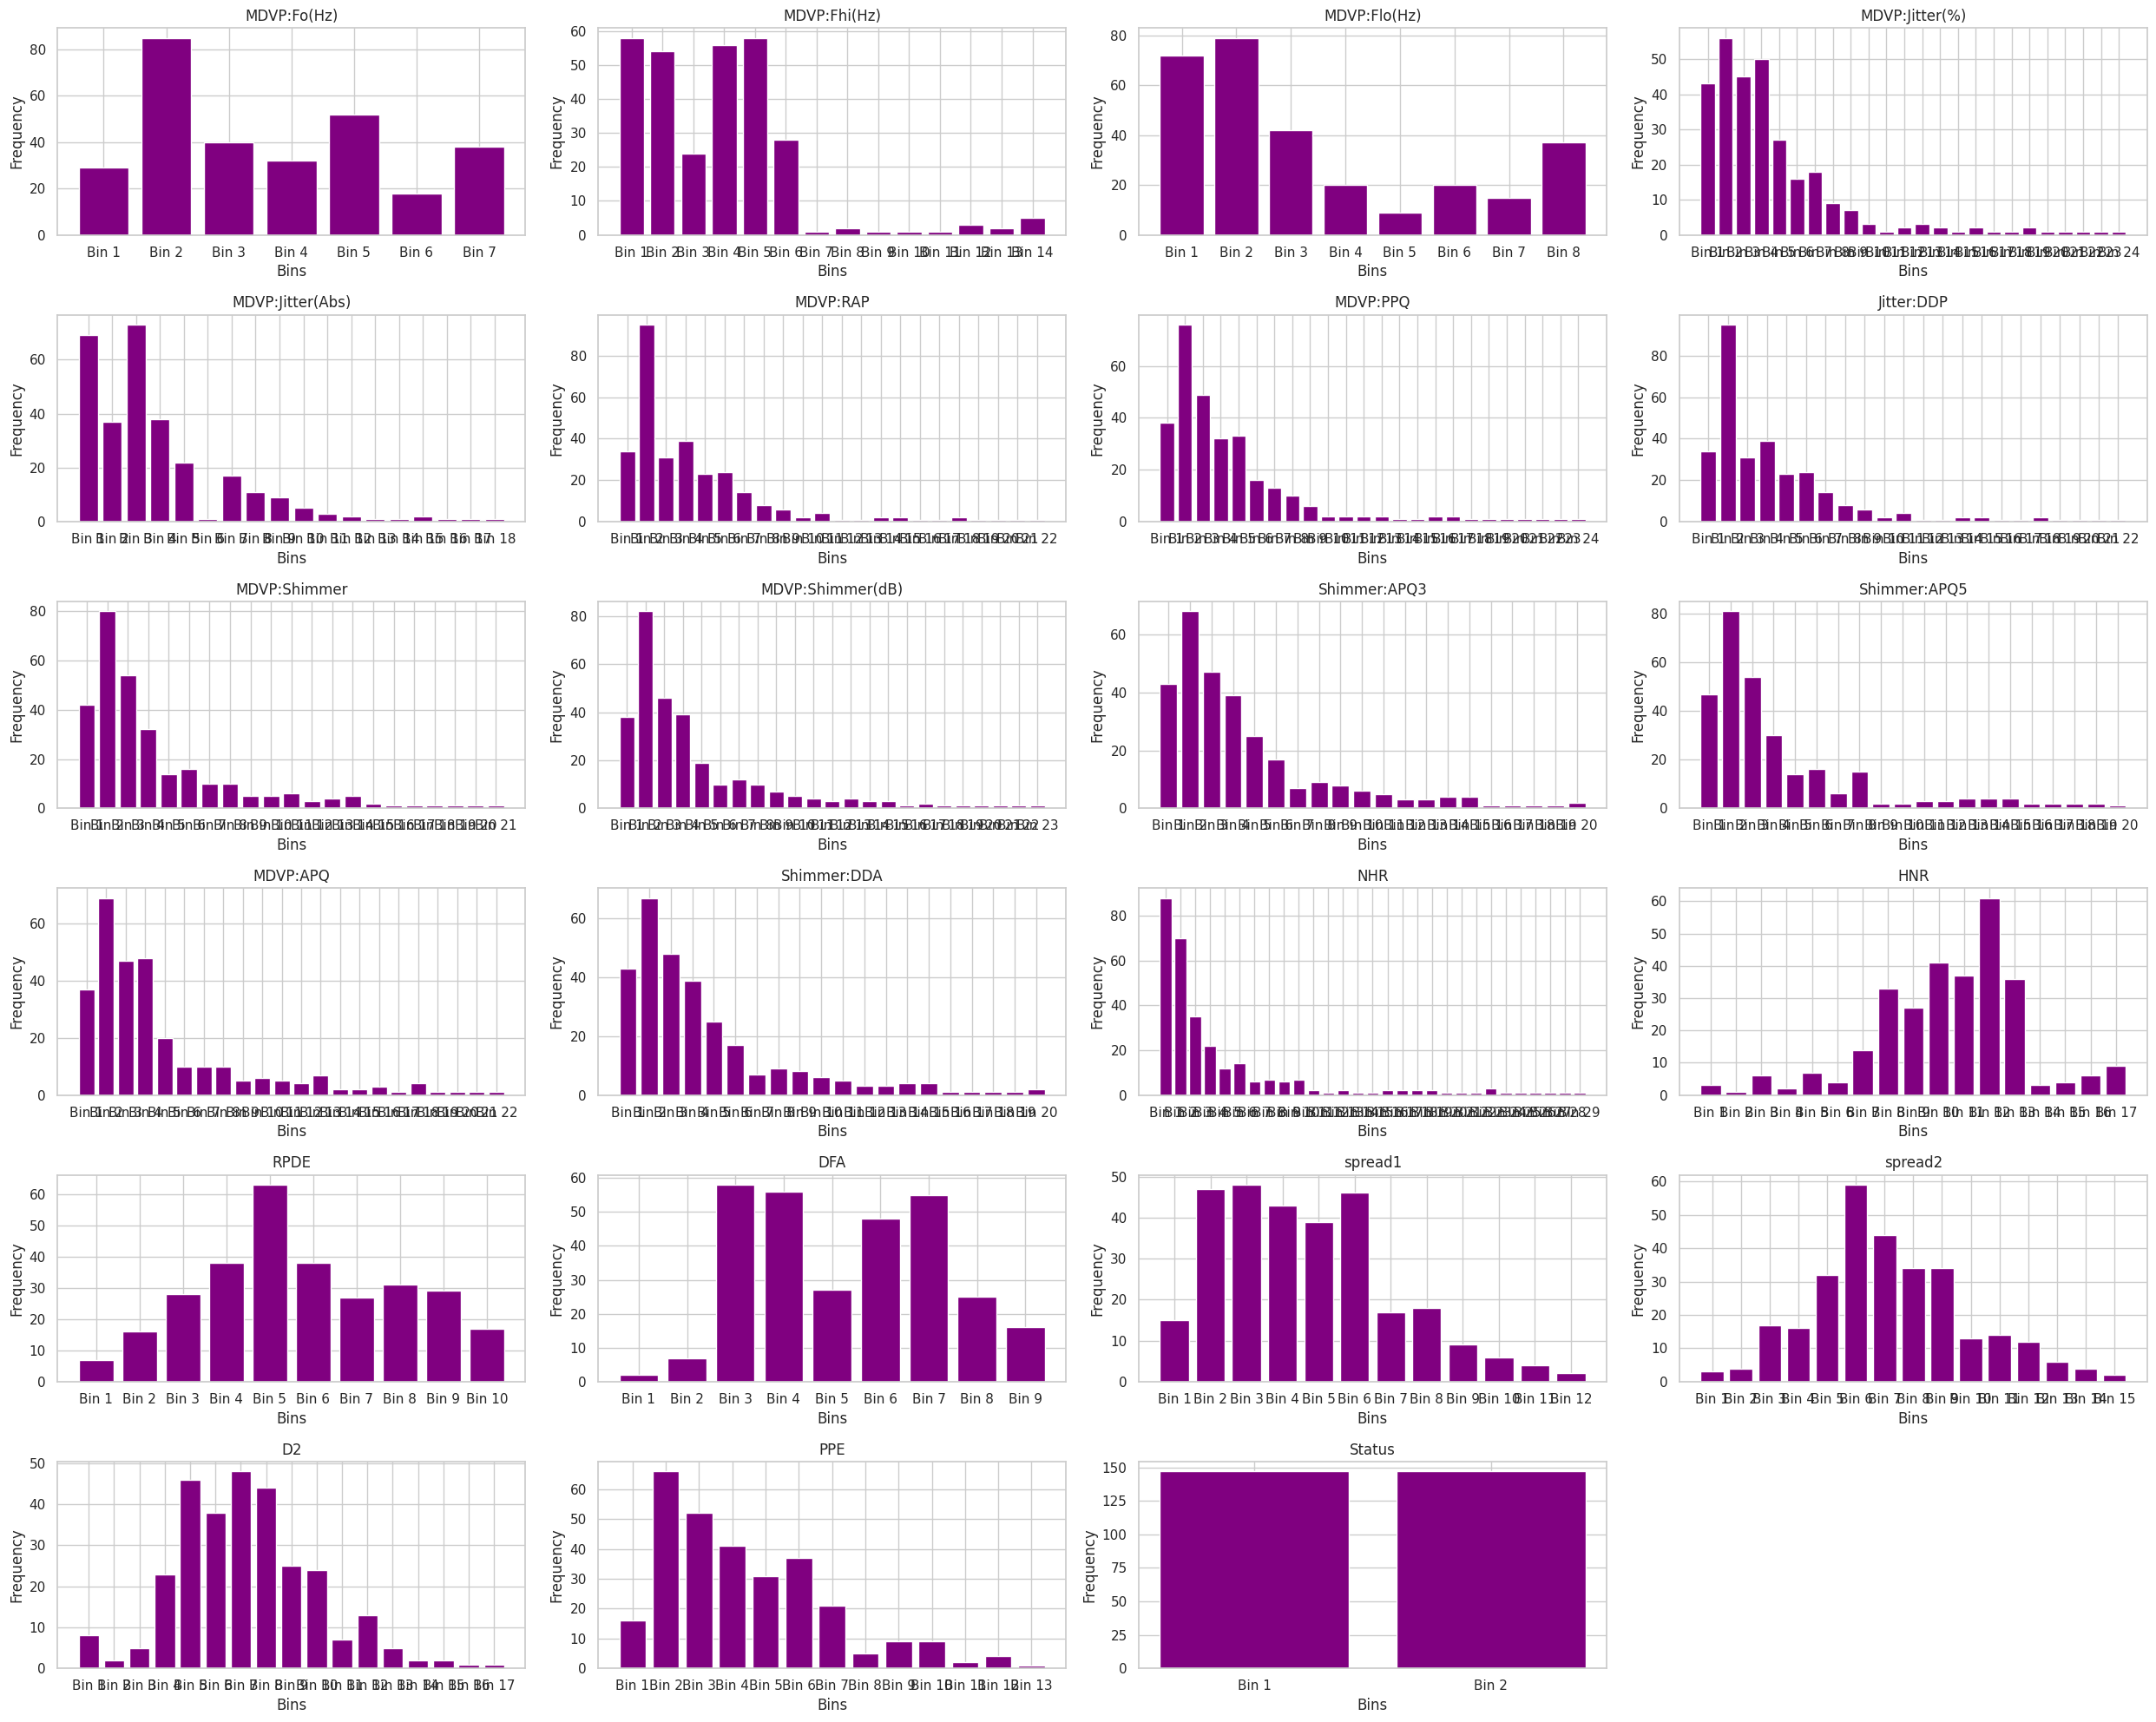

In [42]:
plot_bins_barcharts(parkinsons_df_freedman_diaconis)

### Comparing Discretisation Methods
---

In [43]:
mse_5bins = mean_squared_error(parkinsons_df, parkinsons_df_5bins)
mse_sturges = mean_squared_error(parkinsons_df, parkinsons_df_sturges)
mse_freedman_diaconis = mean_squared_error(parkinsons_df, parkinsons_df_freedman_diaconis)

In [44]:
mse_values = [mse_5bins, mse_sturges, mse_freedman_diaconis]

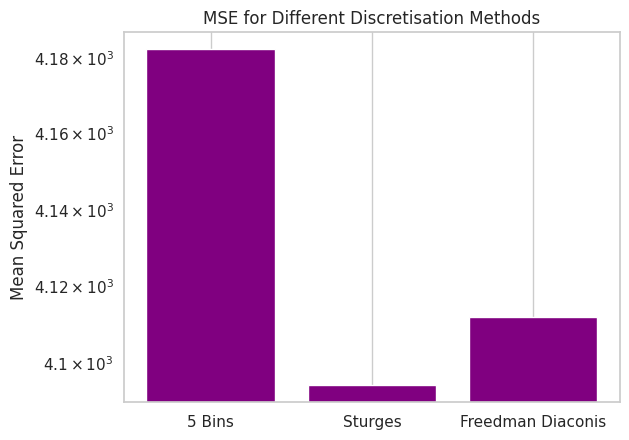

In [45]:
plt.bar(['5 Bins', 'Sturges', 'Freedman Diaconis'], mse_values)
plt.title('MSE for Different Discretisation Methods')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.show()

This time it seems that the Sturges method performs better, so we will use that.

In [46]:
parkinsons_df = parkinsons_df_sturges.copy()
parkinsons_df.describe().T

count      mean       std  min  25%  50%  75%  max
MDVP:Fo(Hz)       294.0  3.969388  2.799759  0.0  1.0  3.0  6.0  9.0
MDVP:Fhi(Hz)      294.0  1.591837  1.675990  0.0  0.0  2.0  2.0  9.0
MDVP:Flo(Hz)      294.0  3.132653  3.056815  0.0  1.0  2.0  5.0  9.0
MDVP:Jitter(%)    294.0  0.741497  1.345393  0.0  0.0  0.0  1.0  9.0
MDVP:Jitter(Abs)  294.0  0.710884  1.220453  0.0  0.0  0.0  1.0  9.0
MDVP:RAP          294.0  0.588435  1.227112  0.0  0.0  0.0  1.0  9.0
MDVP:PPQ          294.0  0.666667  1.260226  0.0  0.0  0.0  1.0  9.0
Jitter:DDP        294.0  0.588435  1.227112  0.0  0.0  0.0  1.0  9.0
MDVP:Shimmer      294.0  0.979592  1.518799  0.0  0.0  0.0  1.0  9.0
MDVP:Shimmer(dB)  294.0  0.840136  1.381850  0.0  0.0  0.0  1.0  9.0
Shimmer:APQ3      294.0  1.248299  1.722046  0.0  0.0  1.0  2.0  9.0
Shimmer:APQ5      294.0  0.819728  1.408707  0.0  0.0  0.0  1.0  9.0
MDVP:APQ          294.0  0.540816  1.103841  0.0  0.0  0.0  1.0  9.0
Shimmer:DDA       294.0  1.248299  1.722046  0.0  0.0  1.0  2.0  9.0
NHR               294.0  0.326531  1.036292  0.0  0.0  0.0  0.0  9.0
HNR               294.0  5.333333  1.746115  0.0  4.0  5.5  6.0  9.0
RPDE              294.0  4.734694  2.308396  0.0  3.0  4.0  7.0  9.0
DFA               294.0  4.870748  2.153724  0.0  3.0  5.0  7.0  9.0
spread1           294.0  2.982993  1.969837  0.0  1.0  3.0  4.0  9.0
spread2           294.0  3.935374  1.794733  0.0  3.0  4.0  5.0  9.0
D2                294.0  3.425170  1.631446  0.0  2.0  3.0  4.0  9.0
PPE               294.0  2.275510  1.751337  0.0  1.0  2.0  3.0  9.0
Status            294.0  0.500000  0.500853  0.0  0.0  0.5  1.0  1.0

## Learning Structure & Parameters with Cross-Validation
---

Now we will explore the process of structure learning and parameter learning for Bayesian Networks (BNs) using the provided dataset. We will evaluate multiple structure learning methods, perform parameter learning, and assess the results using cross-validation.

Our goals are:
1. To understand the structure of the data using various structure learning algorithms.
2. To learn the parameters of the best structure.
3. To evaluate the performance of each method through cross-validation.

The methods we will use:
1. Tree-Augmented Naive Bayes (TAN)
2. Hill Climbing (HC) with BDeu scoring
3. PC Algorithm

We will then evaluate each method's performance and compare the results.

### Cross-Validation
---

In [47]:
evaluation = {}

#### Tree-Augmented Naive Bayes
---

In [48]:
structure_kwargs_tan = {'methodtype': 'tan', 'class_node': 'Status'}

##### Bayes

In [49]:
evaluation_tan_bayes = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.20154620640057533 | 0.14352602197010625 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16432937792161093 | 0.13056005762650819 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.09313196691837469 | 0.1192148388258599  |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.0915138439410284  | 0.11111111111111112 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 287.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 202.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 225.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 431.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.10it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.19145855953673543 | 0.13938092682054035 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16702859211002533 | 0.1377706208624083  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09699601882012306 | 0.1200572553229558  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.09211002533478103 | 0.11039541957416354 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 382.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.54it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.2025089605734767  | 0.15049683830171634 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16218637992831542 | 0.12773261065943994 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.0960573476702509  | 0.12122854561878953 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.09121863799283154 | 0.11472448057813912 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 297.05it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.89it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.68it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 234.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 209.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.47it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.41it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(0) | 0.23504968383017166 | 0.1492831541218638  |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(1) | 0.12935862691960257 | 0.13799283154121864 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(2) | 0.0935862691960253  | 0.12670250896057347 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(3) | 0.0903342366757001  | 0.10734767025089606 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 350.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 444.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 390.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 433.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 400.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.55it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 421.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.32it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 236.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 404.58it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.2054034711039542  | 0.14887082204155375 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16514582215065307 | 0.12610659439927732 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09268205403471104 | 0.11960252935862692 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.08946144211844695 | 0.11635049683830172 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 360.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 411.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 241.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 187.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 223.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.75it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.18it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.22it/s]


In [50]:
evaluation['Tree-Augmented Naive Bayes (Bayes)'] = evaluation_tan_bayes

##### Maximum Likelihood

In [51]:
evaluation_tan_ml = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+----------------------+
| Status          | Status(0)           | Status(1)            |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(0) | 0.5847457627118644  | 0.28205128205128205  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(1) | 0.3898305084745763  | 0.21367521367521367  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(2) | 0.01694915254237288 | 0.15384615384615385  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(3) | 0.00847457627118644 | 0.1111111111111111   |
+-----------------+---------------------+---------

100%|██████████| 1/1 [00:00<00:00, 315.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 200.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.72it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+----------------------+----------------------+
| Status         | Status(0)            | Status(1)            |
+----------------+----------------------+----------------------+
| Shimmer:DDA(0) | 0.543859649122807    | 0.256198347107438    |
+----------------+----------------------+----------------------+
| Shimmer:DDA(1) | 0.41228070175438597  | 0.24793388429752067  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(2) | 0.03508771929824561  | 0.15702479338842976  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(3) | 0.008771929824561403 | 0.10743801652892562  |
+----------------+----------------------+----------

100%|██████████| 1/1 [00:00<00:00, 391.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 413.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 445.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 223.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 422.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 413.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 424.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.58it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(0) | 0.5833333333333334   | 0.3217391304347826   |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(1) | 0.375                | 0.2                  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(2) | 0.03333333333333333  | 0.16521739130434782  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(3) | 0.008333333333333333 | 0.13043478260869565  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 353.50it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.23it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.28it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]

Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22



100%|██████████| 1/1 [00:00<00:00, 392.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.49it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 419.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.31it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(0) | 0.7739130434782608   | 0.30833333333333335  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(1) | 0.20869565217391303  | 0.25                 |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(2) | 0.017391304347826087 | 0.19166666666666668  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(3) | 0.0                  | 0.09166666666666666  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 357.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 412.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 215.32it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 407.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.24it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 444.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 425.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 420.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 443.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.79it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+----------------------+
| Status         | Status(0)           | Status(1)            |
+----------------+---------------------+----------------------+
| Shimmer:DDA(0) | 0.5950413223140496  | 0.3130434782608696   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(1) | 0.3884297520661157  | 0.19130434782608696  |
+----------------+---------------------+----------------------+
| Shimmer:DDA(2) | 0.01652892561983471 | 0.1565217391304348   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(3) | 0.0                 | 0.1391304347826087   |
+----------------+---------------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 384.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 227.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.29it/s]

[bnlearn]> Remaining columns for inference: 22



100%|██████████| 1/1 [00:00<00:00, 300.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 411.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 228.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.79it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.68it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.39it/s]


In [52]:
evaluation['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = evaluation_tan_ml

#### Hill Climbing
---

In [53]:
structure_kwargs_hc = {'methodtype': 'hc', 'scoretype': 'bdeu'}

##### Bayes

In [54]:
evaluation_hc_bayes = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.20154620640057533 | 0.14352602197010625 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16432937792161093 | 0.13056005762650819 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.09313196691837469 | 0.1192148388258599  |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.0915138439410284  | 0.11111111111111112 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 344.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 196.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 142.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 404.47it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.19145855953673543 | 0.13938092682054035 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16702859211002533 | 0.1377706208624083  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09699601882012306 | 0.1200572553229558  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.09211002533478103 | 0.11039541957416354 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 323.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 408.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 390.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 435.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.99it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.2025089605734767  | 0.15049683830171634 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16218637992831542 | 0.12773261065943994 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.0960573476702509  | 0.12122854561878953 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.09121863799283154 | 0.11472448057813912 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 291.19it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.88it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 415.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 185.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.52it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 218.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.60it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 419.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 234.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.99it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(0) | 0.23504968383017166 | 0.1492831541218638  |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(1) | 0.12935862691960257 | 0.13799283154121864 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(2) | 0.0935862691960253  | 0.12670250896057347 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(3) | 0.0903342366757001  | 0.10734767025089606 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 332.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 404.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.51it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.57it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 400.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 417.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 408.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 407.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.12it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.2054034711039542  | 0.14887082204155375 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16514582215065307 | 0.12610659439927732 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09268205403471104 | 0.11960252935862692 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.08946144211844695 | 0.11635049683830172 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 372.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.19it/s]

[bnlearn]> Remaining columns for inference: 22



100%|██████████| 1/1 [00:00<00:00, 390.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 166.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 241.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 239.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.47it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.88it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.20it/s]


In [55]:
evaluation['BDeu Hill Climbing (Bayes)'] = evaluation_hc_bayes

##### Maximum Likelihood

In [56]:
evaluation_hc_ml = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+----------------------+
| Status          | Status(0)           | Status(1)            |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(0) | 0.5847457627118644  | 0.28205128205128205  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(1) | 0.3898305084745763  | 0.21367521367521367  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(2) | 0.01694915254237288 | 0.15384615384615385  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(3) | 0.00847457627118644 | 0.1111111111111111   |
+-----------------+---------------------+---------

100%|██████████| 1/1 [00:00<00:00, 338.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 412.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 230.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 414.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 430.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.86it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+----------------------+----------------------+
| Status         | Status(0)            | Status(1)            |
+----------------+----------------------+----------------------+
| Shimmer:DDA(0) | 0.543859649122807    | 0.256198347107438    |
+----------------+----------------------+----------------------+
| Shimmer:DDA(1) | 0.41228070175438597  | 0.24793388429752067  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(2) | 0.03508771929824561  | 0.15702479338842976  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(3) | 0.008771929824561403 | 0.10743801652892562  |
+----------------+----------------------+----------

100%|██████████| 1/1 [00:00<00:00, 316.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 424.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 431.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 412.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 424.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 233.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 137.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 427.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 230.18it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(0) | 0.5833333333333334   | 0.3217391304347826   |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(1) | 0.375                | 0.2                  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(2) | 0.03333333333333333  | 0.16521739130434782  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(3) | 0.008333333333333333 | 0.13043478260869565  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 400.33it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 420.23it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 431.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 457.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 415.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.23it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 230.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 417.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 415.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.30it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 241.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 414.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.21it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(0) | 0.7739130434782608   | 0.30833333333333335  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(1) | 0.20869565217391303  | 0.25                 |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(2) | 0.017391304347826087 | 0.19166666666666668  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(3) | 0.0                  | 0.09166666666666666  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 405.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 464.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 458.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 440.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 422.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 421.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 420.57it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.09it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 219.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 429.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 214.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 415.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.31it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+----------------------+
| Status         | Status(0)           | Status(1)            |
+----------------+---------------------+----------------------+
| Shimmer:DDA(0) | 0.5950413223140496  | 0.3130434782608696   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(1) | 0.3884297520661157  | 0.19130434782608696  |
+----------------+---------------------+----------------------+
| Shimmer:DDA(2) | 0.01652892561983471 | 0.1565217391304348   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(3) | 0.0                 | 0.1391304347826087   |
+----------------+---------------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 335.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 203.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 427.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.99it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.38it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.55it/s]


In [57]:
evaluation['BDeu Hill Climbing (Maximum Likelihood)'] = evaluation_hc_ml

#### PC Algorithm
---

In [58]:
structure_kwargs_pc = {'methodtype': 'pc'}

##### Bayes

In [59]:
evaluation_pc_bayes = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.20154620640057533 | 0.14352602197010625 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16432937792161093 | 0.13056005762650819 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.09313196691837469 | 0.1192148388258599  |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.0915138439410284  | 0.11111111111111112 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 327.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 203.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 239.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 400.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 230.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.05it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.19145855953673543 | 0.13938092682054035 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16702859211002533 | 0.1377706208624083  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09699601882012306 | 0.1200572553229558  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.09211002533478103 | 0.11039541957416354 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 297.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 239.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 390.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 203.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 209.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.68it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.2025089605734767  | 0.15049683830171634 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16218637992831542 | 0.12773261065943994 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.0960573476702509  | 0.12122854561878953 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.09121863799283154 | 0.11472448057813912 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 325.77it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 419.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.29it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 233.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.26it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 234.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 221.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.82it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 142.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.80it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(0) | 0.23504968383017166 | 0.1492831541218638  |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(1) | 0.12935862691960257 | 0.13799283154121864 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(2) | 0.0935862691960253  | 0.12670250896057347 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(3) | 0.0903342366757001  | 0.10734767025089606 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 379.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 223.57it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 419.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.56it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 400.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 217.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.47it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.2054034711039542  | 0.14887082204155375 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16514582215065307 | 0.12610659439927732 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09268205403471104 | 0.11960252935862692 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.08946144211844695 | 0.11635049683830172 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 302.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 106.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 400.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.78it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 221.56it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.50it/s]


In [60]:
evaluation['PC Algorithm (Bayes)'] = evaluation_pc_bayes

##### Maximum Likelihood

In [61]:
evaluation_pc_ml = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+----------------------+
| Status          | Status(0)           | Status(1)            |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(0) | 0.5847457627118644  | 0.28205128205128205  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(1) | 0.3898305084745763  | 0.21367521367521367  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(2) | 0.01694915254237288 | 0.15384615384615385  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(3) | 0.00847457627118644 | 0.1111111111111111   |
+-----------------+---------------------+---------

100%|██████████| 1/1 [00:00<00:00, 323.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 441.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 429.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 463.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 417.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.20it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+----------------------+----------------------+
| Status         | Status(0)            | Status(1)            |
+----------------+----------------------+----------------------+
| Shimmer:DDA(0) | 0.543859649122807    | 0.256198347107438    |
+----------------+----------------------+----------------------+
| Shimmer:DDA(1) | 0.41228070175438597  | 0.24793388429752067  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(2) | 0.03508771929824561  | 0.15702479338842976  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(3) | 0.008771929824561403 | 0.10743801652892562  |
+----------------+----------------------+----------

100%|██████████| 1/1 [00:00<00:00, 390.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 210.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 414.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 239.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 415.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 432.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 427.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 427.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 437.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.73it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(0) | 0.5833333333333334   | 0.3217391304347826   |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(1) | 0.375                | 0.2                  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(2) | 0.03333333333333333  | 0.16521739130434782  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(3) | 0.008333333333333333 | 0.13043478260869565  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 402.76it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 422.00it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.09it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 420.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 411.13it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 414.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.18it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(0) | 0.7739130434782608   | 0.30833333333333335  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(1) | 0.20869565217391303  | 0.25                 |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(2) | 0.017391304347826087 | 0.19166666666666668  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(3) | 0.0                  | 0.09166666666666666  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 351.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 435.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 404.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.06it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.36it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 426.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 413.76it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+----------------------+
| Status         | Status(0)           | Status(1)            |
+----------------+---------------------+----------------------+
| Shimmer:DDA(0) | 0.5950413223140496  | 0.3130434782608696   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(1) | 0.3884297520661157  | 0.19130434782608696  |
+----------------+---------------------+----------------------+
| Shimmer:DDA(2) | 0.01652892561983471 | 0.1565217391304348   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(3) | 0.0                 | 0.1391304347826087   |
+----------------+---------------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 378.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 400.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 421.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 417.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.68it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.99it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.75it/s]


In [62]:
evaluation['PC Algorithm (Maximum Likelihood)'] = evaluation_pc_ml

## Evaluation
---

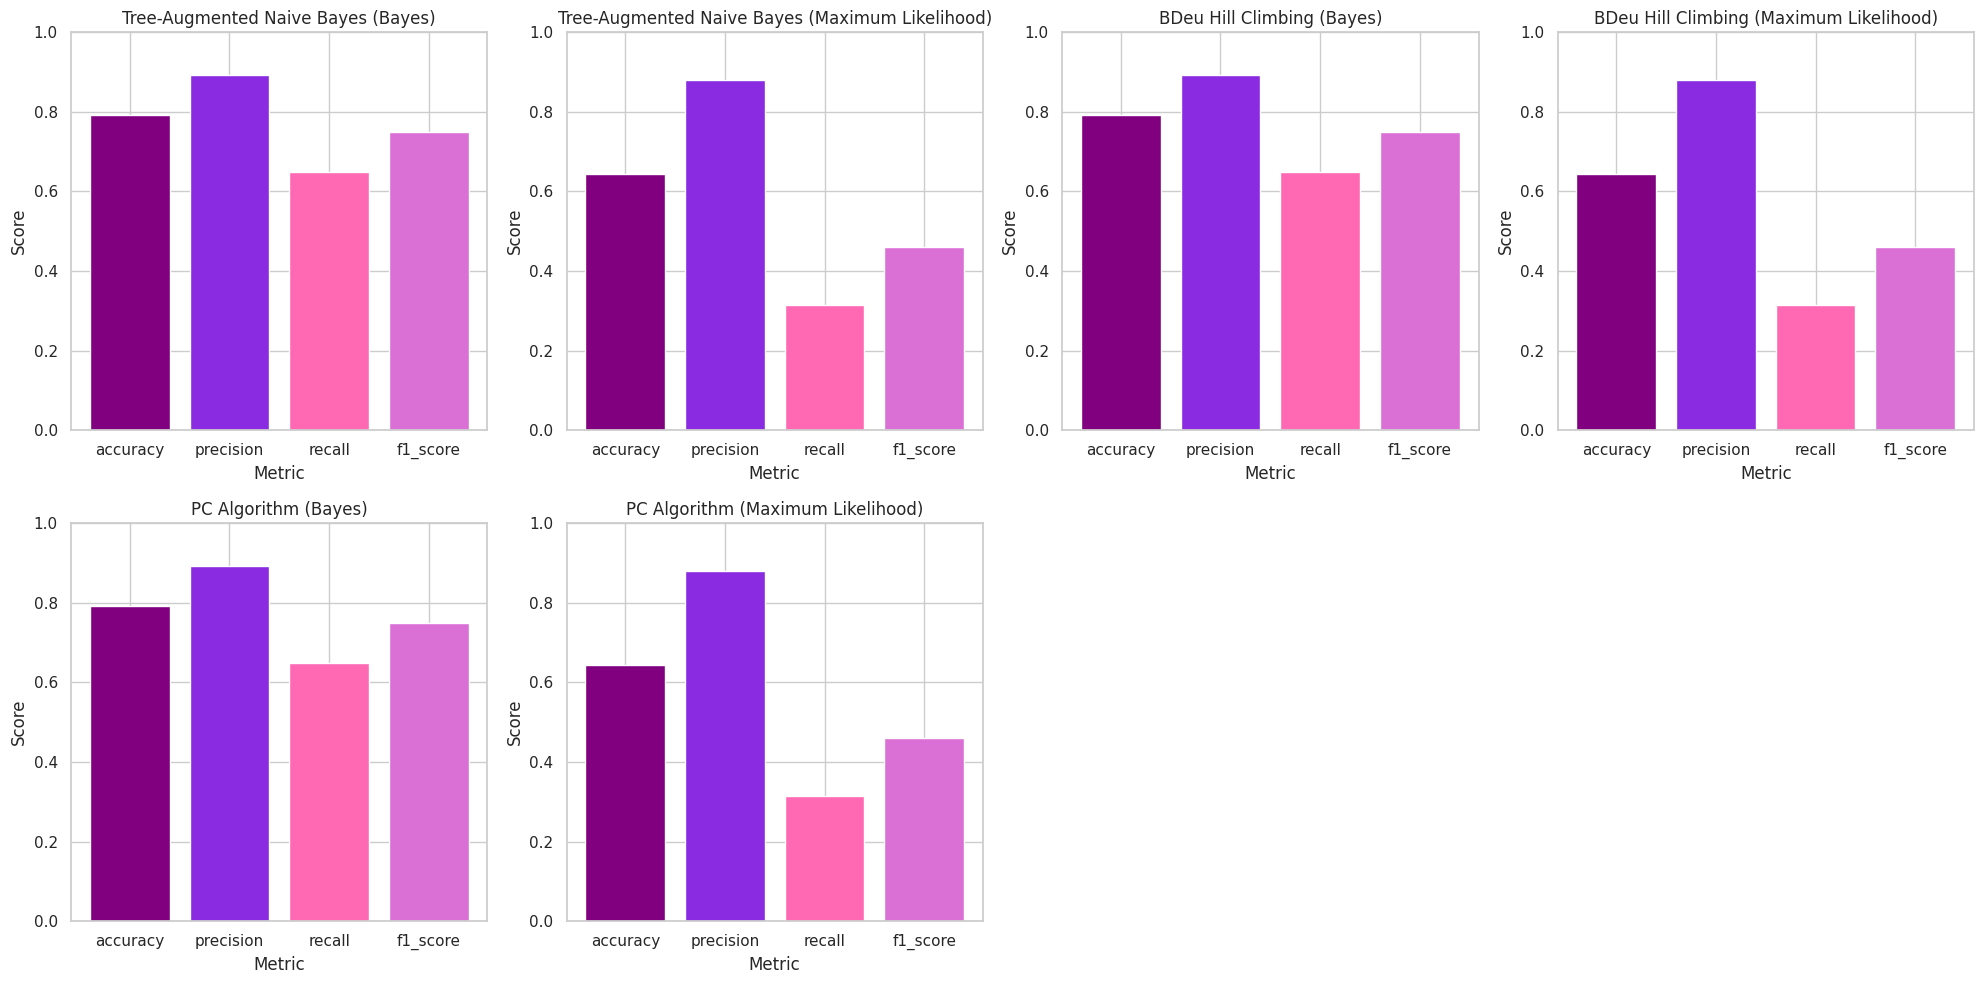

In [63]:
plot_metrics_from_evaluation(evaluation)

In [64]:
display_evaluation_results(evaluation)


Tree-Augmented Naive Bayes (Bayes):
  Metrics:
    Classification:
      Accuracy: 79.15%
      Precision: 89.30%
      Recall: 64.79%
      F1_score: 75.06%
    Roc_auc: 0.7874958507950487
    Brier_score: 0.20853999498314355
    Log_loss: 7.516543296940656
  Time Taken: 44.58 seconds
  Confusion Matrix: [135  12]
                    [44 95]

Tree-Augmented Naive Bayes (Maximum Likelihood):
  Metrics:
    Classification:
      Accuracy: 64.43%
      Precision: 87.89%
      Recall: 31.39%
      F1_score: 46.08%
    Roc_auc: 0.635602393220427
    Brier_score: 0.3556900431067776
    Log_loss: 12.82036862770083
  Time Taken: 8.61 seconds
  Confusion Matrix: [139   8]
                    [94 45]

BDeu Hill Climbing (Bayes):
  Metrics:
    Classification:
      Accuracy: 79.15%
      Precision: 89.30%
      Recall: 64.79%
      F1_score: 75.06%
    Roc_auc: 0.7874958507950487
    Brier_score: 0.20853999498314355
    Log_loss: 7.516543296940656
  Time Taken: 39.53 seconds
  Confusion Matrix

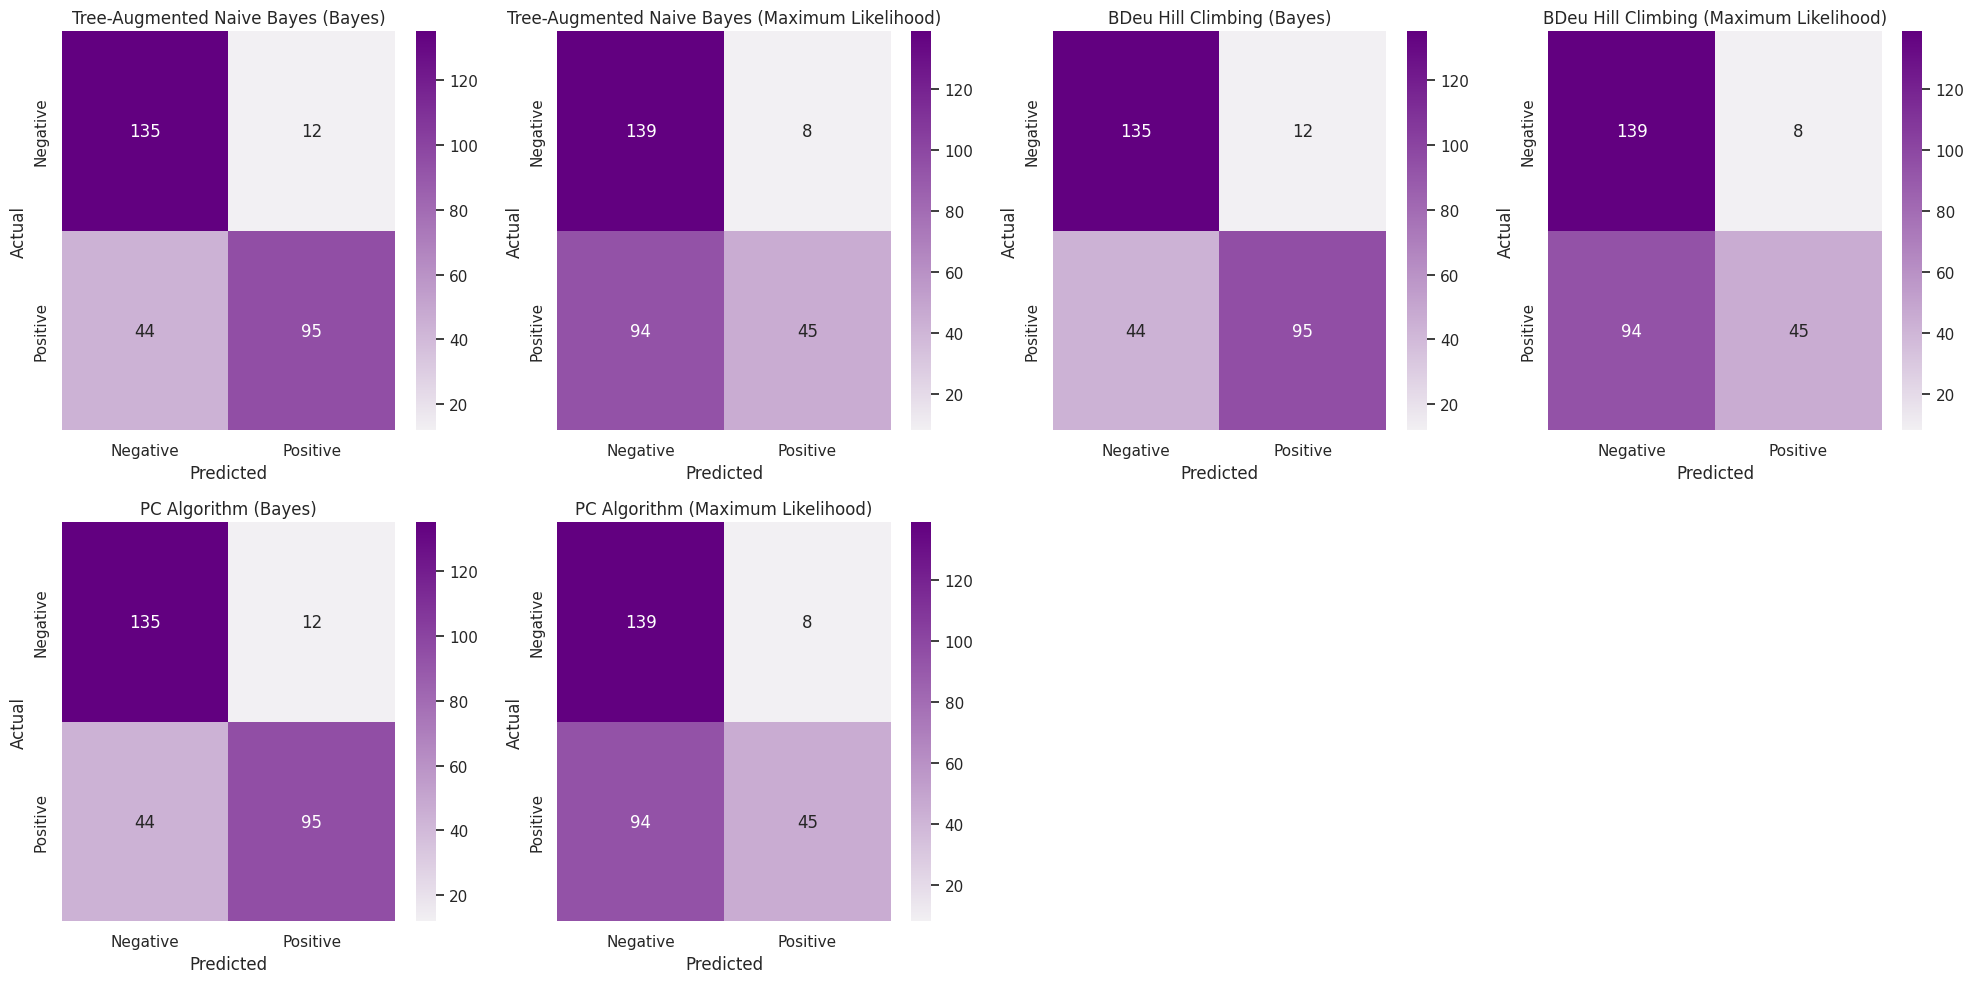

In [65]:
plot_confusion_matrices_from_evaluation(evaluation, cmap=gradient_palette)